> 
<p style="line-height:1.4; font-size:400%; text-align:center; font-weight: bold;">
Water supplies forecasting with neural networks and genetic algorithms
</p>

In [ ]:
import pandas as pd
import numpy as np
import os

from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import MinMaxScaler

from keras import models, layers, Model
from keras.layers import Input, Dense, Concatenate, Activation #,LSTM
from keras.utils.generic_utils import get_custom_objects
import keras.backend as K
from keras.callbacks import ModelCheckpoint
from keras.models import load_model

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import style

from IPython.display import Markdown as md

# Keras custom activation functions.
def cuadratic(x):
    return 0.00000001*x*x

get_custom_objects().update({'cos':K.cos, 'sin':K.sin, 'cuadratic':cuadratic})

# Plot options. 
#style.use('dark_background') # If you use dark mode.
mpl.rcParams['figure.dpi']=200

In [ ]:
# Function for visualize original and cleaned data.

def vis_orig_vs_clean(rows, columns, plot_columns, cols, yl, fs=(10, 10), xticks_rate=1):

    global df_before
    
    mpl.rcParams['axes.titlepad'] = 13
    fig, ax = plt.subplots(rows, columns, figsize=fs)

    for i,j in zip(range(1, rows + 1), plot_columns):

        if i == 1: 
            ax1 = plt.subplot(rows, columns, 2*(i-1) + 1, title=cols[j])
            ax1.text(0.5, 1.4, 'Original', horizontalalignment='center', fontweight='bold', fontsize=20, transform=ax1.transAxes)
        elif i == rows:
            plt.subplot(rows, columns, 2*(i-1) + 1, title=cols[j])
            plt.xlabel('Date', fontsize=10, labelpad=8)
        else:
            plt.subplot(rows, columns, 2*(i-1) + 1, title=cols[j])

        plt.ylabel(yl[i-1], fontsize=10)
        plt.plot(df_before[cols[j]], lw=0.5)

        if i == 1: 
            ax2 = plt.subplot(rows, columns, 2*i, title=cols[j])
            ax2.text(0.5, 1.4, 'Cleaned', horizontalalignment='center', fontweight='bold', fontsize=20, transform=ax2.transAxes)
        elif i == rows:
            plt.subplot(rows, columns, 2*i, title=cols[j])
            plt.xlabel('Date', fontsize=10, labelpad=8)
        else:
            plt.subplot(rows, columns, 2*i, title=cols[j])

        plt.plot(df[cols[j]], lw=0.5)

    for ax in fig.axes:
        ax.tick_params(labelrotation=0, labelsize=8)
        ax.xaxis.set_major_locator(mpl.dates.YearLocator(base=xticks_rate))
        ax.xaxis.set_major_formatter(mpl.dates.DateFormatter('%Y'))

    plt.tight_layout(h_pad=3.0, w_pad=2.0)
    plt.show()

In [ ]:
# Function to plot final results.

def plotResults(forecast1, real1, forecast2, real2, yl=['Depth (m)', 'Depth (m)']):

    mpl.rcParams['axes.titlepad'] = 13
    fig, ax = plt.subplots(2, 1, figsize=(10,12))

    plt.subplot(211)
    plt.title('Best Model Results', fontsize=16)
    plt.ylabel(yl[0], fontsize=10, labelpad=8)
    plt.xlabel('Date', fontsize=10, labelpad=8)
    plt.plot(df.loc[point_start:point_end].index, real1, label='Train + Validation + Test')
    plt.plot(df.loc[point_start:point_end].index, forecast1, label='Forecast')
    plt.legend()

    plt.subplot(212)
    plt.title('Best Model Results', fontsize=16)
    plt.ylabel(yl[1], fontsize=10, labelpad=8)
    plt.xlabel('Date', fontsize=10, labelpad=8)
    plt.plot(df.loc[point_partition_1:point_end].index, real2, label='Validation + Test')
    plt.plot(df.loc[point_partition_1:point_end].index, forecast2, label='Forecast')
    plt.legend()
    
    plt.tight_layout(h_pad=4.0)
    plt.show()

In [ ]:
# Function to plot forecasts without validation data.

def forecast(days_to_predict = 90, yl='Depth (m)'):
    global point_end
    global point_start
    global train_data
    global validation_data
    global tes_data
    global model
    global scaler
    global real1
    dates1 = [pd.to_datetime(point_end) + pd.Timedelta(weeks=i) for i in range(int(days_to_predict/7))]
    x = np.array(list(range(test_data[-1].astype(int), test_data[-1].astype(int) + days_to_predict, 7))).astype(float)
    x = x[1:]
    validation = np.concatenate((train_data.ravel(), validation_data.ravel(), test_data.ravel(), x))
    forecast = model.predict(validation)
    forecast = scaler.inverse_transform(forecast)
    
    n0 = len(dates1)
    n1 = len(x)
    n2 = len(real1)
    n3 = len(forecast)
    
    dates2 = [pd.to_datetime(point_start) + pd.Timedelta(weeks=i) for i in range(n2)]
    
    #dates2 = [pd.to_datetime(point_start) + pd.Timedelta(weeks=n1) for i in range(int(n1))]

    plt.figure(figsize=(10,5))
    plt.title('Best model results')
    plt.ylabel(yl, fontsize=10, labelpad=8)
    plt.xlabel('Date', fontsize=10, labelpad=8)
    plt.plot(dates2, real1, label='Train + Validation + Test')
    plt.plot(dates2, forecast[:n2], label='Tests Forecast')
    plt.plot(dates1, forecast[-n0:], label='New Forecast')
    plt.legend()
    plt.show()

# Introduction

In this notebook I'll introduce the method used for predicting some characteristics of diverses classes of waterbodies which are in Italy.

This waterbodies are divided in four categories:

* Aquifers
* Lakes
* Rivers
* Water springs

For each category there is one or more waterbodies to analize:

Aquifers:
  + Aquifer Auser
  + Aquifer Doganella
  + Aquifer Luco
  + Aquifer Petrignano
  
Lakes:
  + Lake Bilancino
  
Rivers:
  + River Arno
  
Water springs:
  + Water Spring Amiata
  + Water Spring Lupa
  + Water Spring Madonna di Canneto

Each waterbodie has associated a table with numerical data, in which each column consist in a time series with information about measures of rainfall, temperature, volume, depth to ground water or hydrometry, obtained in regions related to the waterbodie.
For example this is how the table of Auser aquifer looks like:

In [ ]:
# Import database.

df = pd.read_csv("../input/aceawaterprediction/Aquifer_Auser.csv")

# Convert 'Date' to date-time type and set it as index.
df['Date'] = pd.to_datetime(df['Date'], format='%d/%m/%Y')
df.set_index('Date', inplace=True)

df

# Model description

The methods I implement consists in a neural network, which is inspired in Fourier Analisys, and a genetic algorithm that searches for suitable hyperparameters for the net. It has the advantage of only needs the a time variable to predict new values and in spite of being a neural network it isn't a black box at all, because it only has one hidden layer with simple activations functions, therefore a mathematical model can be easily extracted from the net as will be explained below.

## Neural network

With Fourier Analisys you can decompose a signal or time series $f$ into a sum of sine a cosine functions with different amplitudes and frequencies, as can be seen in equation below:

$$ f(t_k) = c + \sum_{i=1}^{n-1} a_i\sin \left( \frac{2\pi it_k}{T} \right) + b_i\cos \left( \frac{2\pi it_k}{T} \right) $$

where $n$ is the number of points in $f$, $t_k$ is the discrete time variable, related to point $k$ in the series, $T = t_{\text{max}} - t_0$ and $c$ is a bias correction constant that also can be seen as the $i=0$ term in the sum.

The coefficients $a_i$ and $b_i$ can be calculated in order to the sum of sine and cosine functions does match with every point in the original series.

However, in spite of the perfect accuracy of the above function for known points it isn't a good model for forecasting the future, because for times grater than $t_{\text{max}}$ it only repeats the same values from $t_0$ to $t_{\text{max}}$ periodically. This is roughly because the sum is composed of periodic functions that doesn't admit frequencies greater than the period or domain of the original time series

Nevertheless, there is a clear periodicity in many of the time series to predict. So what I did was relax the rigidity of the original Fourier decomposition and let a neural network to learn the natural frequencies of the time series, including those related to arbritary long time periods, which is very useful to predict the future.

For example, a time series to train the network could encompass a time period of two months, but this isn't an obstacle for the network to learn patterns and trends that could last 4 months or one year, to say something, in addition to the patterns that are alredy present in the series.

So the network used is showed in the next picture.

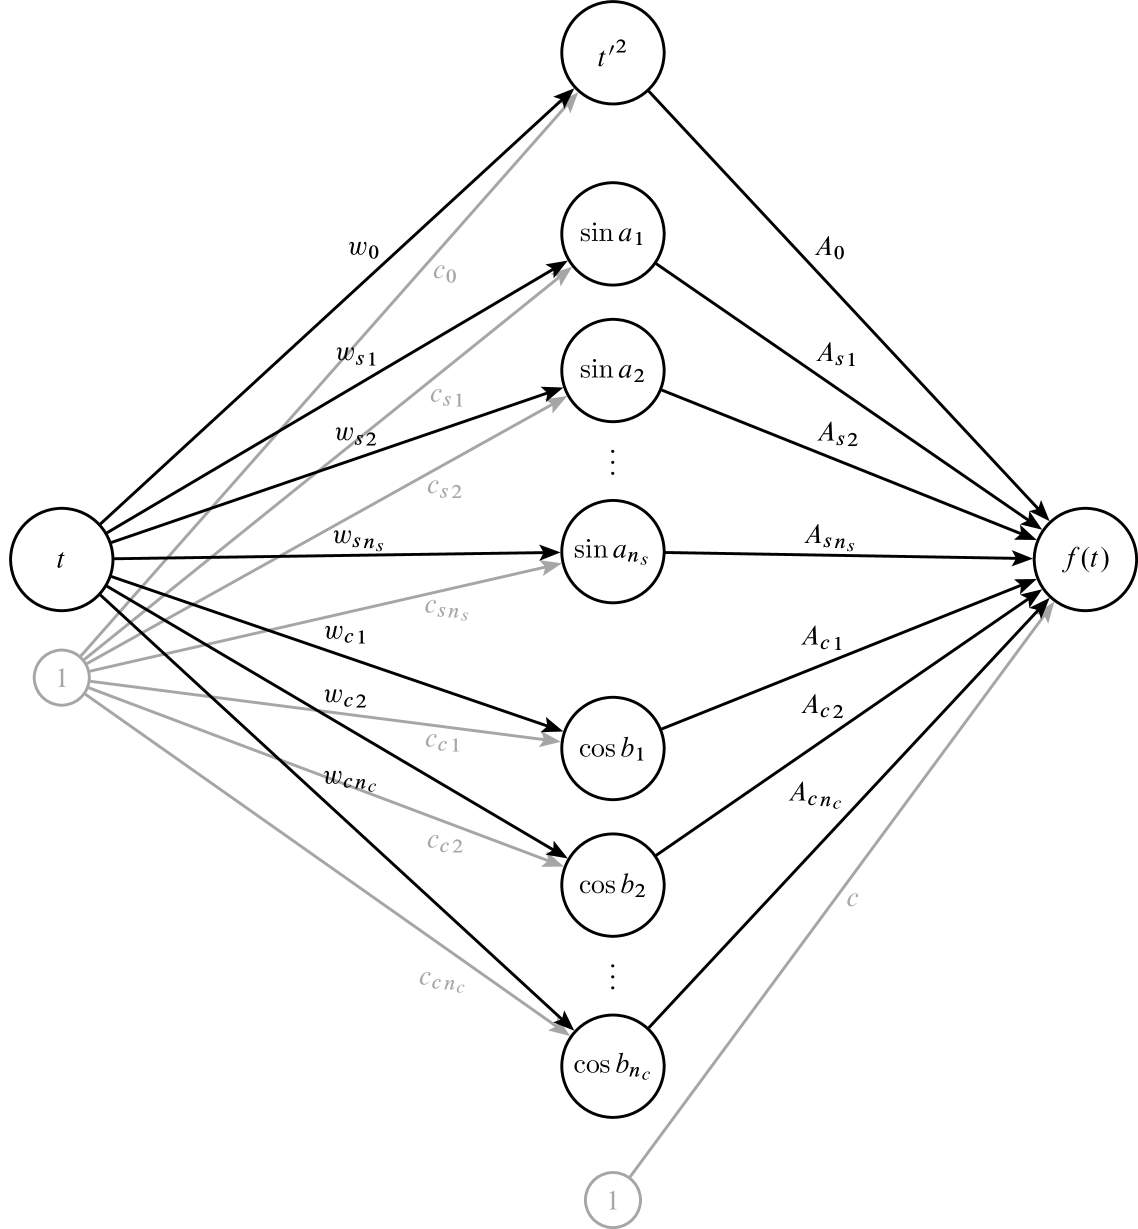

where $t$ is the time-related value of a point in the series, so $t$ values are only a linear succesion of numbers (like [0,1,2,3 ...] or [0,2,4,6 ...], $f(t)$ is the net output, the value that is desired to match with the corresponding of the column to predict and:

\begin{align}
    &a_i = {w_s}_it + {c_s}_i \\ 
    &b_i = {w_c}_it + {c_c}_i \\
    &t' = (w_0t + c_0)^2
\end{align}

After training the network to approximate $f(t)$ to the series to predict we get the learned coefficients $w$'s, $c$'s and $A$'s, and we can meke predictions for $t$ greater than its maximum value given in the training.
Then, mathematicaly $f(t)$ is expressed as:

$$f(t) = c + A_0{t'}^2 + \sum_{i=1}^{n_s} {A_s}_i\sin a_i + \sum_{i=1}^{n_c} {A_c}_i\cos b_i$$

A quadratic term ${t'}^2$ is included in the net because a linear or a very smooth quadratic long-term trend is observed in most of the series. It could be different to quadratic, but due to the forecasts are not so far of this trend I think this approximation is enough.

## Genetic algorithm

Once the net architecture is ready, we just need to set an appropiate number of sine nodes $n_s$ and cosine nodes $n_c$, and other hyperparameters like the batch size we are going to use in training, etc.

For this, I implement a genetic algorithm that searches for a suitable number of sine nodes, cosine nodes and batch size to train the network, based on the validation accuracy (MAE) that a net has for a given set of this parameters.

The main steps of the genetic algorithm are listed below:

* Create a population of 50 models (neural networks) with a random number for each hyperparameter (number of sine nodes, number of cosine nodes, batch size) between a min and max value for each one; and train all models with the current series train data base.


* Choose 25 pairs (parents) of models randomly, a model can be in more than one pair. For each pair generate a new model (descendant) based on the hyperparameters of the parents. There are two methods for this: one consists on set each hyperparameter of the descendant equal to the one of any of its parents with a coin toss; the other method consists on set each hyperparameter equal to the sum of the parents values divided by 2. The selection of the method is made with a coin toss. A component of each descendant could be randomly changed (mutated) with certain low probability.


* Once we get the 25 descendants we train it and we evaluate the 75 models accuracy with the current series validation data base. The 50 best evaluated models survive and conform a new generation, the rest are ignored.


* Repeat the three previous points for as many generations you want (10 in this case) and return the best model od the last generation.

Since the models evaluation is based on the MAE of the validation data base, they could be biased or overfitted to perform well on this data base, but not in future data. For that reason a second partition of the series to predict is made: the test data base. This base is the final portion of the series to predict and I give more weight to the MAE of this base to choose a good model, so the best model is chosen based on the following metric:

$$ E = 0.25(\text{training MAE}) + 0.25(\text{validation MAE}) + 0.5(\text{test MAE}) $$

The model of the final generation with the lowest $E$ value is chosen as the best and returned by the algorithm. However I highly recommend to explore the other last generation models, specially the models with index `scores[i][1]`, for the first values of `i`, because `scores` has the best scores $E$ of the last generation sorted, in the form `[score, model index]`. This can be done just changing the last line of the algorithm function `return popul[score[0][1]][1]` to `return popul` for returning all 50 last generation models and then explore the `i`'st model: `popul[i][1]`.

Finally the MAE and RMSE errors for each series are calculated in a normal way with the validation + test databases, since any of these sub-series are seen by the models during their training.

<font color='yellow'>**Warning**</font>: As you can note, the algorithm function is commented and instead, a pre-builded model is loaded in the next cell this is because one run of this function takes about two hours in a 4-core i7 7th generation processor, 8gb RAM lap-top with no GPU card.

In [ ]:
# Auxiliar functions and main genetic algorithm.

# Create individual from his gene, return a list with the gene, the correspondent model and its score.
def createIndividual(gen):

    epoc = 500
    
    il = Input(shape=1)
    
    l1 = Dense(gen[1], activation=K.sin)(il)
    l2 = Dense(gen[2], activation=K.cos)(il)
    l3 = Dense(1, activation='cuadratic')(il)
    lc1 = Concatenate()([l1, l2, l3])
    
    ol = Dense(1, activation='linear')(lc1)
    
    model = Model(inputs=il, outputs=ol)
    
    callbacks_list = [ModelCheckpoint(filepath='best_model.h5', monitor='val_loss', save_best_only=True)]
    
    model.compile(optimizer='adam', loss='mae')
    history = model.fit(train_data, train_target_data, verbose=0, epochs=epoc, batch_size=gen[0], validation_data=(validation_data, validation_target_data), callbacks=callbacks_list)
    
    model = load_model('../input/aceawaterprediction-models/best_model.h5')
    os.remove('best_model.h5')

    return [gen, model, min(history.history['val_loss'])]

# Function for sorting genes by validation score.
def customOrder(elem):
    return elem[2]

# Main algorithm.
def geneticAlgorithm(train_data, train_target_data, validation_data, validation_target_data, test_data, 
                     test_target_data, max_batch_size, popul_inic = 50, parents_pairs = 25, sons_per_pair = 1, 
                     prob_mutation = 0.05, num_generations = 10, max_sin = 200, max_cos = 200):

    # gen: [Batch size, sin() number, cos() number].
    # gen limits, including both extremes.
    gen_limits = [[1, max_batch_size], [0, max_sin], [0, max_cos]]


    # Individuals list: [gen, model, score].
    popul = [[None, None, 0.0] for i in range(popul_inic)]

    # Descendants list. Same strucre as 'popul'.
    desc = [[None, None, 0.0] for i in range(parents_pairs*sons_per_pair)]

    # Initialize population.
    for i in range(popul_inic):

        print("Generating initial population, individual", i+1, '.')

        batch_s = np.random.randint(max_batch_size) + 1
        num_sin = np.random.randint(max_sin + 1)
        num_cos = np.random.randint(max_cos + 1)
        popul[i] = createIndividual([batch_s, num_sin, num_cos])
        #popul[i] = crearIndividuo([batch_s, num_sin])

        print("Gene:", popul[i][0], "Val. MAE:", popul[i][2])

    # Generation of descendants through generations (main part of the algorithm).
    for i in range(num_generations):

        #Print info.
        print("Generating population (generation", i,"):")
        for p in range(popul_inic): print(popul[p][0], popul[p][2])

        # Couples selection and descendendants generation.
        for j in range(parents_pairs):

            # Parents selection.
            ind1 = 0; ind2 = 0
            while ind1 == ind2:
                ind1 = np.random.randint(popul_inic)
                ind2 = np.random.randint(popul_inic)

            # Parents decendants.
            for k in range(sons_per_pair):

                # Gene obtained from the parents.
                gen = [0 for i in range(len(popul[0][0]))]   # Empty gene.
                for l in range(len(gen)):
                    # Coin toss.
                    if np.random.randint(2):
                        gen[l] = popul[ind1][0][l] if np.random.randint(2) else popul[ind2][0][l]
                    else:
                        gen[l] = int((popul[ind1][0][l] + popul[ind2][0][l])/2)

                # Mutate descendant.
                if np.random.rand() <= prob_mutation:
                    elem = np.random.randint(len(gen))
                    gen[elem] = np.random.randint(gen_limits[elem][0], gen_limits[elem][1]+1)

                desc[j*sons_per_pair + k] = createIndividual(gen)

        # Population substitution of worst members with best descendendants, based on their scores.

        popul_aux = popul + desc
        # Print info.
        print("Descendants (generation", i,"):")
        for d in range(len(desc)): print(desc[d][0], desc[d][2])
        popul_aux.sort(key=customOrder)

        popul = popul_aux[:popul_inic]

    # Print final population info.
    print("Final population:")
    for p in range(len(popul)): print(popul[p][0], popul[p][2])

    # Choose the best individual based on the established metric.
    scores = [[0.0,0] for i in range(len(popul))]    # Variable for saving scores and models index.
    for i in range(len(popul)):

        train_pred = popul[i][1].predict(train_data)
        train_score = 0.25*mean_absolute_error(train_target_data, train_pred)
        validation_pred = popul[i][1].predict(validation_data)
        validation_score = 0.25*mean_absolute_error(validation_target_data, validation_pred)
        test_pred = popul[i][1].predict(test_data)
        test_score = 0.5*mean_absolute_error(test_target_data, test_pred)
        score = train_score + validation_score + test_score

        scores[i] = [score, i]

    scores.sort()

    print(f'Best score correspond to model with index {scores[0][1]}.')

    # Return the best model.
    return popul[scores[0][1]][1]

Before starting with the process for each waterbody I like to point out some considerations about the data cleaning of all of them.

***Note about data cleaning:*** Data cleaning of all series to predict consist mainly on removing or displacing outliers and interpolating `NaN` values. In some cases there is a group of points that exhibit an uncommon behaviour, like suddenly increase or decrease a relatively large amount of units, giving place to an anomalous peak or valley. Even if this behaviour is real, I decided to remove or replace this kind of points in the cases that this behaviours only happens few times (1 or 2), because there isn't enough information for the model to learn the cause or pattern that is behind this conduct. So it's likely that this points, instead adding useful information to the model, they could be confusing it.

So I decided to keep the main trend of the series by sacrificing a bit of real data, in order to get a better learning of this main trend and predict it more accurately.

For the same reason I also fill some large holes of `NaN` values with another period of the series that seems congruent with its main trend and thus get more training or validation data.

#  How to run the code?

* First run every cell above this section in order.

* Then for each waterbodie subsection (like Aquifer Auser), you must first run the code inside *Data cleaning* sub-subsection in order.

* Then you can run the code inside any column sub-subsection (like *Depth to Groundwater LT2*) in order, if you go to another waterbodie subsection, return to point 2.

# Aquifers

## Aquifer Auser

### Data cleaning

First of all we need to clean and preprocess the columns we are going to work with, in order to our algorithm performs the most efficiently possible.
These columns are `Depth_to_Groundwater_LT2`, `Depth_to_Groundwater_SAL`, `Depth_to_Groundwater_PAG`, `Depth_to_Groundwater_CoS` and `Depth_to_Groundwater_DIEC`.

The changes made to each of this columns are explained below.

* `Depth_to_Groundwater_LT2`: Here we remove the two outliers at the end of the series, because they are introducing noise to the regular behaviour seen in the plot. So this two points are converted to `NaN` and then interpolated with the points immediately after and before of them.
The rest missing values are also interpolated.


* `Depth_to_Groundwater_SAL`: Same case as `Depth_to_Groundwater_LT2`, the outliers are converted to `NaN` and then interpolated, the rest of missing values are also interpolated.


* `Depth_to_Groundwater_PAG`: Here, the hole of missing values in 2014 is filled ...


* `Depth_to_Groundwater_CoS`: Same case as `Depth_to_Groundwater_LT2` and `Depth_to_Groundwater_SAL`.


* `Depth_to_Groundwater_DIEC`: A point is included in this series in order to get a more consistent pattern in the plot when the missing values are interpolated later.

As I metioned before, all this columns were subsampled to week frequency by mean. 

This plots corresponds to the columns to analize before and after the data cleaning.

In [ ]:
# Import database.

df = pd.read_csv("../input/aceawaterprediction/Aquifer_Auser.csv")

# Convert 'Date' to date-time type and set it as index.
df['Date'] = pd.to_datetime(df['Date'], format='%d/%m/%Y')
df.set_index('Date', inplace=True)

In [ ]:
# Dictionary of integers to columns names for shorter code.

cols1 = {
    0:'Rainfall_Gallicano',
    1:'Rainfall_Pontetetto',
    2:'Rainfall_Monte_Serra',
    3:'Rainfall_Orentano',
    4:'Rainfall_Borgo_a_Mozzano',
    5:'Rainfall_Piaggione',
    6:'Rainfall_Calavorno',
    7:'Rainfall_Croce_Arcana',
    8:'Rainfall_Tereglio_Coreglia_Antelminelli',
    9:'Rainfall_Fabbriche_di_Vallico',
    10:'Depth_to_Groundwater_LT2',
    11:'Depth_to_Groundwater_SAL',
    12:'Depth_to_Groundwater_PAG',
    13:'Depth_to_Groundwater_CoS',
    14:'Depth_to_Groundwater_DIEC',
    15:'Temperature_Orentano',
    16:'Temperature_Monte_Serra',
    17:'Temperature_Ponte_a_Moriano',
    18:'Temperature_Lucca_Orto_Botanico',
    19:'Volume_POL',
    20:'Volume_CC1',
    21:'Volume_CC2',
    22:'Volume_CSA',
    23:'Volume_CSAL',
    24:'Hydrometry_Monte_S_Quirico',
    25:'Hydrometry_Piaggione',
}

In [ ]:
# Clean data.

# Save original series.
df_before = df.copy()

# Convert outliers to NaN and interpolate missing values in 'Depth_to_Groundwater_LT2'.
df.loc[df[cols1[10]] > -1, cols1[10]] = np.nan
df[cols1[10]] = df[cols1[10]].interpolate()

# Convert outliers to NaN and interpolate missing values in 'Depth_to_Groundwater_SAL'.
df.loc[df[cols1[11]] > -1, cols1[11]] = np.nan
df[cols1[11]] = df[cols1[11]].interpolate()

# Convert outliers to NaN and interpolate missing values in 'Depth_to_Groundwater_CoS'.
df.loc[df[cols1[13]] > -1, cols1[13]] = np.nan
df[cols1[13]] = df[cols1[13]].interpolate()

# Include a point to get a better patern and interpolate missing values in 'Depth_to_Groundwater_DIEC'.
df.loc['2020-03-29', cols1[14]] = -3.9
df[cols1[14]] = df[cols1[14]].interpolate()

df_aux = df.copy()

In [ ]:
# Visualize original and cleaned data.
df = df.resample(rule='W').mean()
vis_orig_vs_clean(3, 2, [10,11,13], cols1, yl=['Depth (m)']*3, fs=(10, 10), xticks_rate=2)

### Depth to Groundwater LT2

For this series I decided to truncate it to the domain 2015-04-16 to 2020-07-01, because this is a more regular period with a clear pattern and contains the most recent data with an aceptable number of points.

As validation data I chose a the six month period, from 2019-07-01 to 2020-01-01, and for test data, the last six month period, from 2020-01-01 to 2020-07-01.

All three series, train + validation + test are shown below:

In [ ]:
# Key number of the column to predict.
col_target = 10

# Partition points for train, validation and test.

point_start = '2015-04-16'
point_partition_1 = '2019-07-01'
point_partition_2 = '2020-01-01'
point_end = '2020-07-01'

In [ ]:
# Visualize train + validation + test data for Depth to Groundwater LT2.

plt.figure(figsize=(10,5))
plt.title('Depth to Groundwater LT2')
plt.ylabel('Depth (m)', fontsize=10, labelpad=8)
plt.xlabel('Date', fontsize=10, labelpad=8)
plt.plot(df.loc[point_start:point_partition_1, cols1[col_target]], label='Train')
plt.plot(df.loc[point_partition_1:point_partition_2, cols1[col_target]], label='Validation')
plt.plot(df.loc[point_partition_2:point_end, cols1[col_target]], label='Test')
plt.legend()
plt.show()

In [ ]:
# Select domain to analize.
df = df_aux.copy()
df = df.loc[point_start:point_end]

# Add the integer type time column.
df.insert(len(df.columns), 't', np.array(range(len(df))).astype('float64'), True) 

df = df.resample(rule='W').mean()

# Scale the series to 0-1 domain to feed neural networks.
scaler = MinMaxScaler()
scaler.fit(df[[cols1[col_target]]])
df[[cols1[col_target]]] = scaler.transform(df[[cols1[col_target]]])

# Divide series into train, validation and test.
train_data_aux = df[point_start:point_partition_1]
validation_data_aux = df[point_partition_1:point_partition_2]
test_data_aux = df[point_partition_2:point_end]

train_data = train_data_aux['t']
train_target_data =  train_data_aux[cols1[col_target]]
validation_data = validation_data_aux['t']
validation_target_data = validation_data_aux[cols1[col_target]]
test_data = test_data_aux['t']
test_target_data = test_data_aux[cols1[col_target]]
              
train_data = train_data.to_numpy()
train_target_data = train_target_data.to_numpy()
validation_data = validation_data.to_numpy()
validation_target_data = validation_target_data.to_numpy()

In [ ]:
# Run genetic algorithm.

#model = geneticAlgorithm(train_data, train_target_data, validation_data, validation_target_data, test_data, 
#                         test_target_data, max_batch_size = int(len(train_data)/2), popul_inic = 50, 
#                         parents_pairs = 25, sons_per_pair = 1, prob_mutation = 0.05, num_generations = 10, 
#                         max_sin = 200, max_cos = 200)

In [ ]:
model = load_model('../input/aceawaterprediction-models/AA_DGLT2.h5')

After running the genetic algorithm and getting the best model, the forecasting results are the following:

In [ ]:
# Calculate MAE and RMSE and plot results.

# Plot train + validation + test forecast,
# and validation + test forecast.

forecast1 = model.predict(np.concatenate((train_data, validation_data, test_data)))

forecast1 = scaler.inverse_transform(forecast1)
real1 = scaler.inverse_transform(df.loc[point_start:point_end, [cols1[col_target]]])

forecast2 = model.predict(np.concatenate((validation_data, test_data)))

forecast2 = scaler.inverse_transform(forecast2)
real2 = scaler.inverse_transform(df.loc[point_partition_1:point_end, [cols1[col_target]]])

plotResults(forecast1, real1, forecast2, real2, yl=['Hydrometry']*2)

MAE = mean_absolute_error(real2, forecast2)
RMSE = np.sqrt(mean_squared_error(real2, forecast2))

The error of the model forecast for validation + test data is:

<font size="6">**MAE = 0.0505**</font>

<font size="6">**RMSE = 0.0644**</font>

In [ ]:
print(MAE)
print(RMSE)

With this model, you can make predictions only based on time (very far future predictions could be less accurate).

In [ ]:
forecast(days_to_predict = 365)

### Depth to Groundwater SAL

The used data for this series is in the domain that begins in 2013-08-02, because from this point, a more regular behaviour begins in the series.

All three series, train + validation + test are shown below:

In [ ]:
# Key number of the column to predict.
col_target = 11

# Partition points for train, validation and test.

point_start = '2013-08-02'
point_partition_1 = '2019-07-01'
point_partition_2 = '2020-01-01'
point_end = '2020-07-01'

In [ ]:
# Visualize train + validation + test data.

plt.figure(figsize=(10,5))
plt.title('Depth to Groundwater SAL')
plt.ylabel('Depth (m)', fontsize=10, labelpad=8)
plt.xlabel('Date', fontsize=10, labelpad=8)
plt.plot(df.loc[point_start:point_partition_1, cols1[col_target]], label='Train')
plt.plot(df.loc[point_partition_1:point_partition_2, cols1[col_target]], label='Validation')
plt.plot(df.loc[point_partition_2:point_end, cols1[col_target]], label='Test')
plt.legend()
plt.show()

In [ ]:
# Select domain to analize.
df = df_aux.copy()
df = df.loc[point_start:point_end]

# Add the integer type time column.
df.insert(len(df.columns), 't', np.array(range(len(df))).astype('float64'), True) 

df = df.resample(rule='W').mean()

# Scale the series to 0-1 domain to feed neural networks.
scaler = MinMaxScaler()
scaler.fit(df[[cols1[col_target]]])
df[[cols1[col_target]]] = scaler.transform(df[[cols1[col_target]]])

# Divide series into train, validation and test.
train_data_aux = df[point_start:point_partition_1]
validation_data_aux = df[point_partition_1:point_partition_2]
test_data_aux = df[point_partition_2:point_end]

train_data = train_data_aux['t']
train_target_data =  train_data_aux[cols1[col_target]]
validation_data = validation_data_aux['t']
validation_target_data = validation_data_aux[cols1[col_target]]
test_data = test_data_aux['t']
test_target_data = test_data_aux[cols1[col_target]]
              
train_data = train_data.to_numpy()
train_target_data = train_target_data.to_numpy()
validation_data = validation_data.to_numpy()
validation_target_data = validation_target_data.to_numpy()

In [ ]:
# Run genetic algorithm.

#model = geneticAlgorithm(train_data, train_target_data, validation_data, validation_target_data, test_data, 
#                         test_target_data, max_batch_size = int(len(train_data)/2), popul_inic = 50, 
#                         parents_pairs = 25, sons_per_pair = 1, prob_mutation = 0.05, num_generations = 10, 
#                         max_sin = 200, max_cos = 200)

In [ ]:
model = load_model('../input/aceawaterprediction-models/AA_DGSAL.h5')

After running the genetic algorithm and getting the best model, the forecasting results are the following:

In [ ]:
# Calculate MAE and RMSE and plot results.

# Plot train + validation + test forecast,
# and validation + test forecast.

forecast1 = model.predict(np.concatenate((train_data, validation_data, test_data)))

forecast1 = scaler.inverse_transform(forecast1)
real1 = scaler.inverse_transform(df.loc[point_start:point_end, [cols1[col_target]]])

forecast2 = model.predict(np.concatenate((validation_data, test_data)))

forecast2 = scaler.inverse_transform(forecast2)
real2 = scaler.inverse_transform(df.loc[point_partition_1:point_end, [cols1[col_target]]])

plotResults(forecast1, real1, forecast2, real2)

MAE = mean_absolute_error(real2, forecast2)
RMSE = np.sqrt(mean_squared_error(real2, forecast2))

The error of the model forecast for validation + test data is:

<font size="6">**MAE = 0.1906**</font>

<font size="6">**RMSE = 0.2692**</font>

In [ ]:
print(MAE)
print(RMSE)

With this model, you can make predictions only based on time (very far future predictions could be less accurate).

In [ ]:
forecast(days_to_predict = 365)

### Depth to Groundwater CoS

In this series, a regular behaviour can be seen from 2015 so this is the starting point for the model's trainning data.

All three series, train + validation + test are shown below:

In [ ]:
# Key number of the column to predict.
col_target = 13

# Partition points for train, validation and test.

point_start = '2015-10-10'
point_partition_1 = '2019-07-01'
point_partition_2 = '2020-01-01'
point_end = '2020-07-01'

In [ ]:
# Visualize train + validation + test data.

plt.figure(figsize=(10,5))
plt.title('Depth to Groundwater CoS')
plt.ylabel('Depth (m)', fontsize=10, labelpad=8)
plt.xlabel('Date', fontsize=10, labelpad=8)
plt.plot(df.loc[point_start:point_partition_1, cols1[col_target]], label='Train')
plt.plot(df.loc[point_partition_1:point_partition_2, cols1[col_target]], label='Validation')
plt.plot(df.loc[point_partition_2:point_end, cols1[col_target]], label='Test')
plt.legend()
plt.show()

In [ ]:
# Select domain to analize.
df = df_aux.copy()
df = df.loc[point_start:point_end]

# Add the integer type time column.
df.insert(len(df.columns), 't', np.array(range(len(df))).astype('float64'), True) 

df = df.resample(rule='W').mean()

# Scale the series to 0-1 domain to feed neural networks.
scaler = MinMaxScaler()
scaler.fit(df[[cols1[col_target]]])
df[[cols1[col_target]]] = scaler.transform(df[[cols1[col_target]]])

# Divide series into train, validation and test.
train_data_aux = df[point_start:point_partition_1]
validation_data_aux = df[point_partition_1:point_partition_2]
test_data_aux = df[point_partition_2:point_end]

train_data = train_data_aux['t']
train_target_data =  train_data_aux[cols1[col_target]]
validation_data = validation_data_aux['t']
validation_target_data = validation_data_aux[cols1[col_target]]
test_data = test_data_aux['t']
test_target_data = test_data_aux[cols1[col_target]]
              
train_data = train_data.to_numpy()
train_target_data = train_target_data.to_numpy()
validation_data = validation_data.to_numpy()
validation_target_data = validation_target_data.to_numpy()

In [ ]:
# Run genetic algorithm.

#model = geneticAlgorithm(train_data, train_target_data, validation_data, validation_target_data, test_data, 
#                         test_target_data, max_batch_size = int(len(train_data)/2), popul_inic = 50, 
#                         parents_pairs = 25, sons_per_pair = 1, prob_mutation = 0.05, num_generations = 10, 
#                         max_sin = 200, max_cos = 200)

In [ ]:
model = load_model('../input/aceawaterprediction-models/AA_DGCOS.h5')

After running the genetic algorithm and getting the best model, the forecasting results are the following:

In [ ]:
# Calculate MAE and RMSE and plot results.

# Plot train + validation + test forecast,
# and validation + test forecast.

forecast1 = model.predict(np.concatenate((train_data, validation_data, test_data)))

forecast1 = scaler.inverse_transform(forecast1)
real1 = scaler.inverse_transform(df.loc[point_start:point_end, [cols1[col_target]]])

forecast2 = model.predict(np.concatenate((validation_data, test_data)))

forecast2 = scaler.inverse_transform(forecast2)
real2 = scaler.inverse_transform(df.loc[point_partition_1:point_end, [cols1[col_target]]])

plotResults(forecast1, real1, forecast2, real2)

MAE = mean_absolute_error(real2, forecast2)
RMSE = np.sqrt(mean_squared_error(real2, forecast2))

The error of the model forecast for validation + test data is:

<font size="6">**MAE = 0.3164**</font>

<font size="6">**RMSE = 0.3953**</font>

In [ ]:
print(MAE)
print(RMSE)

With this model, you can make predictions only based on time (very far future predictions could be less accurate).

In [ ]:
forecast(days_to_predict = 365)

## Aquifer Doganella

### Data cleaning and preprocessing

The columns to be worked with inn this waterbodie are `Depth_to_Groundwater_Pozzo_1` to `Depth_to_Groundwater_Pozzo_9`.

The changes made to each of this columns are:

* `Depth_to_Groundwater_Pozzo_1`: For this column, only the `NaN` values were interpolated.

* `Depth_to_Groundwater_Pozzo_2`: In this column, the outlier at the end of the series was removed (converted to `NaN`) and after this the `NaN` values were interpolated.

* `Depth_to_Groundwater_Pozzo_3`: The peaks and outliers after 2018 in this series were removed. A point at 2019-09-19 is added in order to the result after interpolation would be more congruent with the series.

* `Depth_to_Groundwater_Pozzo_4`: The only thing done in this series was interpolate the `NaN` values.

* `Depth_to_Groundwater_Pozzo_5`: The sharp valley near 2018 was removed and then `NaN` values were interpolated.

* `Depth_to_Groundwater_Pozzo_6`: The outliers between 2019 and 2020 were removed and then an interpolation was performed.

* `Depth_to_Groundwater_Pozzo_7`: The only thing done in this series was interpolate the `NaN` values.

* `Depth_to_Groundwater_Pozzo_8`: Outliers near the end of the series were removed and then interpolated with the rest of `NaN`'s.

* `Depth_to_Groundwater_Pozzo_9`:The only thing done in this series was interpolate the `NaN` values.

After clean all this columns, they all were subsampled to week frequency by mean. 

The following plots correspond to the columns to analize before and after the data cleaning and preprocessing.

In [ ]:
# Import database.

df = pd.read_csv("../input/aceawaterprediction/Aquifer_Doganella.csv")

# Convert 'Date' to date-time type and set it as index.
df['Date'] = pd.to_datetime(df['Date'], format='%d/%m/%Y')
df.set_index('Date', inplace=True)

In [ ]:
# Dictionary of integers to columns names for shorter code.

cols2 = {
    0:'Rainfall_Monteporzio',
    1:'Rainfall_Velletri',
    2:'Depth_to_Groundwater_Pozzo_1',
    3:'Depth_to_Groundwater_Pozzo_2',
    4:'Depth_to_Groundwater_Pozzo_3',
    5:'Depth_to_Groundwater_Pozzo_4',
    6:'Depth_to_Groundwater_Pozzo_5',
    7:'Depth_to_Groundwater_Pozzo_6',
    8:'Depth_to_Groundwater_Pozzo_7',
    9:'Depth_to_Groundwater_Pozzo_8',
    10:'Depth_to_Groundwater_Pozzo_9',
    11:'Volume_Pozzo_1',
    12:'Volume_Pozzo_2',
    13:'Volume_Pozzo_3',
    14:'Volume_Pozzo_4',
    15:'Volume_Pozzo_5+6',
    16:'Volume_Pozzo_7',
    17:'Volume_Pozzo_8',
    18:'Volume_Pozzo_9',
    19:'Temperature_Monteporzio',
    20:'Temperature_Velletri'
}

In [ ]:
# Clean data.

# Save original series.
df_before = df.iloc[:, 2:11].copy()

df[cols2[0]] = df[cols2[0]].interpolate()
df[cols2[1]] = df[cols2[1]].interpolate()
df[cols2[2]] = df[cols2[2]].interpolate()

# Convert outliers to NaN and interpolate in Depth_to_Groundwater_Pozzo_2.
df.loc[df[cols2[3]] < -110, cols2[3]] = np.nan
df[cols2[3]] = df[cols2[3]].interpolate()

# Convert peaks afeter 2018 to NaN, add a point to interpolate and get a more congruent series in 
# Depth_to_Groundwater_Pozzo_3.
#df.loc[df[cols2[4]] > -103, cols2[4]] = np.nan
df.loc[(df.index > '2018') & (df[cols2[4]] > -110), cols2[4]] = np.nan
df.loc['2019-09-19', cols2[4]] = -112.3
df[cols2[4]] = df[cols2[4]].interpolate()

df[cols2[5]] = df[cols2[5]].interpolate()

# Remove the sharp valley near 2018 and interpolate in Depth_to_Groundwater_Pozzo_5.
df.loc[(df.index >= '2017-06-01') & (df.index <='2018-06-01') & (df[cols2[6]] < -104), cols2[6]] = np.nan
df[cols2[6]] = df[cols2[6]].interpolate()

# Convert outliers to NaN and interpolate in Depth_to_Groundwater_Pozzo_6.
df.loc[(df.index >= '2019-01-01') & (df.index <='2020-01-01') & (df[cols2[7]] > -92), cols2[7]] = np.nan
df[cols2[7]] = df[cols2[7]].interpolate()

df[cols2[8]] = df[cols2[8]].interpolate()

# Convert outliers to NaN and interpolate in Depth_to_Groundwater_Pozzo_8.
df.loc[df[cols2[9]] < -106, cols2[9]] = np.nan
df[cols2[9]] = df[cols2[9]].interpolate()

df[cols2[10]] = df[cols2[10]].interpolate()

# Interpolate all volume series.
df.iloc[:, 11:19] = df.iloc[:, 11:19].interpolate()

df_aux = df.copy()

In [ ]:
# Visualize original and cleaned data.
df = df.resample(rule='W').mean()
vis_orig_vs_clean(9, 2, [2,3,4,5,6,7,8,9,10], cols2, yl=['Depth (m)']*9, fs=(10, 27))

### Depth to Groundwater Pozzo 1

There are two marked behaviours before and after 2017 in this series, so I chose the most recent to feed the model.

All three series, train + validation + test are shown below:

In [ ]:
df = df_aux.copy()

# Key number of the column to predict.
col_target = 2

# Partition points for train, validation and test.

point_start = '2017-06-01'
point_partition_1 = '2019-07-01'
point_partition_2 = '2020-01-01'
point_end = '2020-07-01'

In [ ]:
# Visualize train + validation + test data.

plt.figure(figsize=(10,5))
plt.title('Depth to Groundwater Pozzo 1')
plt.ylabel('Depth (m)', fontsize=10, labelpad=8)
plt.xlabel('Date', fontsize=10, labelpad=8)
plt.plot(df.resample(rule='W').mean().loc[point_start:point_partition_1, cols2[col_target]], label='Train')
plt.plot(df.resample(rule='W').mean().loc[point_partition_1:point_partition_2, cols2[col_target]], label='Validation')
plt.plot(df.resample(rule='W').mean().loc[point_partition_2:point_end, cols2[col_target]], label='Test')
plt.legend()
plt.show()

In [ ]:
# Select domain to analize.
df = df_aux.copy()
df = df.loc[point_start:point_end]

# Add the integer type time column.
df.insert(len(df.columns), 't', np.array(range(len(df))).astype('float64'), True) 

df = df.resample(rule='W').mean()

# Scale the series to 0-1 domain to feed neural networks.
scaler = MinMaxScaler()
scaler.fit(df[[cols2[col_target]]])
df[[cols2[col_target]]] = scaler.transform(df[[cols2[col_target]]])

# Divide series into train, validation and test.
train_data_aux = df[point_start:point_partition_1]
validation_data_aux = df[point_partition_1:point_partition_2]
test_data_aux = df[point_partition_2:point_end]

train_data = train_data_aux['t']
train_target_data =  train_data_aux[cols2[col_target]]
validation_data = validation_data_aux['t']
validation_target_data = validation_data_aux[cols2[col_target]]
test_data = test_data_aux['t']
test_target_data = test_data_aux[cols2[col_target]]
              
train_data = train_data.to_numpy()
train_target_data = train_target_data.to_numpy()
validation_data = validation_data.to_numpy()
validation_target_data = validation_target_data.to_numpy()

In [ ]:
# Run genetic algorithm.

#model = geneticAlgorithm(train_data, train_target_data, validation_data, validation_target_data, test_data, 
#                         test_target_data, max_batch_size = int(len(train_data)/2), popul_inic = 50, 
#                         parents_pairs = 25, sons_per_pair = 1, prob_mutation = 0.05, num_generations = 10, 
#                         max_sin = 200, max_cos = 200)

In [ ]:
model = load_model('../input/aceawaterprediction-models/AD_DGP1.h5')

After running the genetic algorithm and getting the best model, the forecasting results are the following:

In [ ]:
# Calculate MAE and RMSE and plot results.

# Plot train + validation + test forecast,
# and validation + test forecast.

forecast1 = model.predict(np.concatenate((train_data, validation_data, test_data)))

forecast1 = scaler.inverse_transform(forecast1)
real1 = scaler.inverse_transform(df.loc[point_start:point_end, [cols2[col_target]]])

forecast2 = model.predict(np.concatenate((validation_data, test_data)))

forecast2 = scaler.inverse_transform(forecast2)
real2 = scaler.inverse_transform(df.loc[point_partition_1:point_end, [cols2[col_target]]])

plotResults(forecast1, real1, forecast2, real2)

MAE = mean_absolute_error(real2, forecast2)
RMSE = np.sqrt(mean_squared_error(real2, forecast2))

The error of the model forecast for validation + test data is:

<font size="6">**MAE = 1.4036**</font>

<font size="6">**RMSE = 1.7816**</font>

In [ ]:
print(MAE)
print(RMSE)

With this model, you can make predictions only based on time (very far future predictions could be less accurate).

In [ ]:
forecast(days_to_predict = 365)

### Depth to Groundwater Pozzo 2

The recent data chosen to train the model for this series begins in 2015.

All three series, train + validation + test are shown below:

In [ ]:
df = df_aux.copy()

# Key number of the column to predict.
col_target = 3

# Partition points for train, validation and test.

point_start = '2015-01-01'
point_partition_1 = '2019-07-01'
point_partition_2 = '2020-01-01'
point_end = '2020-07-01'

In [ ]:
# Visualize train + validation + test data.

plt.figure(figsize=(10,5))
plt.title('Depth to Groundwater Pozzo 2')
plt.ylabel('Depth (m)', fontsize=10, labelpad=8)
plt.xlabel('Date', fontsize=10, labelpad=8)
plt.plot(df.resample(rule='W').mean().loc[point_start:point_partition_1, cols2[col_target]], label='Train')
plt.plot(df.resample(rule='W').mean().loc[point_partition_1:point_partition_2, cols2[col_target]], label='Validation')
plt.plot(df.resample(rule='W').mean().loc[point_partition_2:point_end, cols2[col_target]], label='Test')
plt.legend()
plt.show()

In [ ]:
# Select domain to analize.
df = df.loc[point_start:point_end]

# Add the integer type time column.
df.insert(len(df.columns), 't', np.array(range(len(df))).astype('float64'), True) 

df = df.resample(rule='W').mean()

# Scale the series to 0-1 domain to feed neural networks.
scaler = MinMaxScaler()
scaler.fit(df[[cols2[col_target]]])
df[[cols2[col_target]]] = scaler.transform(df[[cols2[col_target]]])

# Divide series into train, validation and test.
train_data_aux = df[point_start:point_partition_1]
validation_data_aux = df[point_partition_1:point_partition_2]
test_data_aux = df[point_partition_2:point_end]

train_data = train_data_aux['t']
train_target_data =  train_data_aux[cols2[col_target]]
validation_data = validation_data_aux['t']
validation_target_data = validation_data_aux[cols2[col_target]]
test_data = test_data_aux['t']
test_target_data = test_data_aux[cols2[col_target]]
              
train_data = train_data.to_numpy()
train_target_data = train_target_data.to_numpy()
validation_data = validation_data.to_numpy()
validation_target_data = validation_target_data.to_numpy()

In [ ]:
# Run genetic algorithm.

#model = geneticAlgorithm(train_data, train_target_data, validation_data, validation_target_data, test_data, 
#                         test_target_data, max_batch_size = int(len(train_data)/2), popul_inic = 50, 
#                         parents_pairs = 25, sons_per_pair = 1, prob_mutation = 0.05, num_generations = 10, 
#                         max_sin = 200, max_cos = 200)

In [ ]:
model = load_model('../input/aceawaterprediction-models/AD_DGP2.h5')

After running the genetic algorithm and getting the best model, the forecasting results are the following:

In [ ]:
# Calculate MAE and RMSE and plot results.

# Plot train + validation + test forecast,
# and validation + test forecast.

forecast1 = model.predict(np.concatenate((train_data, validation_data, test_data)))

forecast1 = scaler.inverse_transform(forecast1)
real1 = scaler.inverse_transform(df.loc[point_start:point_end, [cols2[col_target]]])

forecast2 = model.predict(np.concatenate((validation_data, test_data)))

forecast2 = scaler.inverse_transform(forecast2)
real2 = scaler.inverse_transform(df.loc[point_partition_1:point_end, [cols2[col_target]]])

plotResults(forecast1, real1, forecast2, real2)

MAE = mean_absolute_error(real2, forecast2)
RMSE = np.sqrt(mean_squared_error(real2, forecast2))

The error of the model forecast for validation + test data is:

<font size="6">**MAE = 0.2887**</font>

<font size="6">**RMSE = 0.3909**</font>

In [ ]:
print(MAE)
print(RMSE)

With this model, you can make predictions only based on time (very far future predictions could be less accurate).

In [ ]:
forecast(days_to_predict = 365)

### Depth to Groundwater Pozzo 3

Same as `Depth_to_Groundwater_Pozzo_1`, there are two behaviours separated by 2017 in this series. So I took the data from 2017 to train the model.

All three series, train + validation + test are shown below:

In [ ]:
df = df_aux.copy()

# Key number of the column to predict.
col_target = 4

# Partition points for train, validation and test.

point_start = '2017-01-01'
point_partition_1 = '2020-01-01'
point_partition_2 = '2020-04-01'
point_end = '2020-07-01'

In [ ]:
# Visualize train + validation + test data.

plt.figure(figsize=(10,5))
plt.title('Depth to Groundwater Pozzo 3')
plt.ylabel('Depth (m)', fontsize=10, labelpad=8)
plt.xlabel('Date', fontsize=10, labelpad=8)
plt.plot(df.resample(rule='W').mean().loc[point_start:point_partition_1, cols2[col_target]], label='Train')
plt.plot(df.resample(rule='W').mean().loc[point_partition_1:point_partition_2, cols2[col_target]], label='Validation')
plt.plot(df.resample(rule='W').mean().loc[point_partition_2:point_end, cols2[col_target]], label='Test')
plt.legend()
plt.show()

In [ ]:
# Select domain to analize.
df = df.loc[point_start:point_end]

# Add the integer type time column.
df.insert(len(df.columns), 't', np.array(range(len(df))).astype('float64'), True) 

df = df.resample(rule='W').mean()

# Scale the series to 0-1 domain to feed neural networks.
scaler = MinMaxScaler()
scaler.fit(df[[cols2[col_target]]])
df[[cols2[col_target]]] = scaler.transform(df[[cols2[col_target]]])

# Divide series into train, validation and test.
train_data_aux = df[point_start:point_partition_1]
validation_data_aux = df[point_partition_1:point_partition_2]
test_data_aux = df[point_partition_2:point_end]

train_data = train_data_aux['t']
train_target_data =  train_data_aux[cols2[col_target]]
validation_data = validation_data_aux['t']
validation_target_data = validation_data_aux[cols2[col_target]]
test_data = test_data_aux['t']
test_target_data = test_data_aux[cols2[col_target]]

train_data = train_data.to_numpy()
train_target_data = train_target_data.to_numpy()
validation_data = validation_data.to_numpy()
validation_target_data = validation_target_data.to_numpy()

In [ ]:
# Run genetic algorithm.

#model = geneticAlgorithm(train_data, train_target_data, validation_data, validation_target_data, test_data, 
#                         test_target_data, max_batch_size = int(len(train_data)/2), popul_inic = 50, 
#                         parents_pairs = 25, sons_per_pair = 1, prob_mutation = 0.05, num_generations = 10, 
#                         max_sin = 200, max_cos = 200)

In [ ]:
model = load_model('../input/aceawaterprediction-models/AD_DGP3.h5')

After running the genetic algorithm and getting the best model, the forecasting results are the following:

In [ ]:
# Calculate MAE and RMSE and plot results.

# Plot train + validation + test forecast,
# and validation + test forecast.

forecast1 = model.predict(np.concatenate((train_data, validation_data, test_data)))

forecast1 = scaler.inverse_transform(forecast1)
real1 = scaler.inverse_transform(df.loc[point_start:point_end, [cols2[col_target]]])

forecast2 = model.predict(np.concatenate((validation_data, test_data)))

forecast2 = scaler.inverse_transform(forecast2)
real2 = scaler.inverse_transform(df.loc[point_partition_1:point_end, [cols2[col_target]]])

plotResults(forecast1, real1, forecast2, real2)

MAE = mean_absolute_error(real2, forecast2)
RMSE = np.sqrt(mean_squared_error(real2, forecast2))

The error of the model forecast for validation + test data is:

<font size="6">**MAE = 0.4114**</font>

<font size="6">**RMSE = 0.6268**</font>

In [ ]:
print(MAE)
print(RMSE)

With this model, you can make predictions only based on time (very far future predictions could be less accurate).

In [ ]:
forecast(days_to_predict = 182)

### Depth to Groundwater Pozzo 4

Same as `Depth_to_Groundwater_Pozzo_3` and `Depth_to_Groundwater_Pozzo_1`, I think the useful data to predict this series begins about 2017.

All three series, train + validation + test are shown below:

In [ ]:
df = df_aux.copy()

# Key number of the column to predict.
col_target = 5

# Partition points for train, validation and test.

point_start = '2017-01-01'
point_partition_1 = '2020-01-01'
point_partition_2 = '2020-04-01'
point_end = '2020-07-01'

In [ ]:
# Visualize train + validation + test data.

plt.figure(figsize=(10,5))
plt.title('Depth to Groundwater Pozzo 4')
plt.ylabel('Depth (m)', fontsize=10, labelpad=8)
plt.xlabel('Date', fontsize=10, labelpad=8)
plt.plot(df.resample(rule='W').mean().loc[point_start:point_partition_1, cols2[col_target]], label='Train')
plt.plot(df.resample(rule='W').mean().loc[point_partition_1:point_partition_2, cols2[col_target]], label='Validation')
plt.plot(df.resample(rule='W').mean().loc[point_partition_2:point_end, cols2[col_target]], label='Test')
plt.legend()
plt.show()

In [ ]:
# Select domain to analize.
df = df.loc[point_start:point_end]

# Add the integer type time column.
df.insert(len(df.columns), 't', np.array(range(len(df))).astype('float64'), True) 

df = df.resample(rule='W').mean()

# Scale the series to 0-1 domain to feed neural networks.
scaler = MinMaxScaler()
scaler.fit(df[[cols2[col_target]]])
df[[cols2[col_target]]] = scaler.transform(df[[cols2[col_target]]])

# Divide series into train, validation and test.
train_data_aux = df[point_start:point_partition_1]
validation_data_aux = df[point_partition_1:point_partition_2]
test_data_aux = df[point_partition_2:point_end]

train_data = train_data_aux['t']
train_target_data =  train_data_aux[cols2[col_target]]
validation_data = validation_data_aux['t']
validation_target_data = validation_data_aux[cols2[col_target]]
test_data = test_data_aux['t']
test_target_data = test_data_aux[cols2[col_target]]
              
train_data = train_data.to_numpy()
train_target_data = train_target_data.to_numpy()
validation_data = validation_data.to_numpy()
validation_target_data = validation_target_data.to_numpy()

In [ ]:
# Run genetic algorithm.

#model = geneticAlgorithm(train_data, train_target_data, validation_data, validation_target_data, test_data, 
#                         test_target_data, max_batch_size = int(len(train_data)/2), popul_inic = 50, 
#                         parents_pairs = 25, sons_per_pair = 1, prob_mutation = 0.05, num_generations = 10, 
#                         max_sin = 200, max_cos = 200)

In [ ]:
model = load_model('../input/aceawaterprediction-models/AD_DGP4.h5')

After running the genetic algorithm and getting the best model, the forecasting results are the following:

In [ ]:
# Calculate MAE and RMSE and plot results.

# Plot train + validation + test forecast,
# and validation + test forecast.

forecast1 = model.predict(np.concatenate((train_data, validation_data, test_data)))

forecast1 = scaler.inverse_transform(forecast1)
real1 = scaler.inverse_transform(df.loc[point_start:point_end, [cols2[col_target]]])

forecast2 = model.predict(np.concatenate((validation_data, test_data)))

forecast2 = scaler.inverse_transform(forecast2)
real2 = scaler.inverse_transform(df.loc[point_partition_1:point_end, [cols2[col_target]]])

plotResults(forecast1, real1, forecast2, real2)

MAE = mean_absolute_error(real2, forecast2)
RMSE = np.sqrt(mean_squared_error(real2, forecast2))

The error of the model forecast for validation + test data is:

<font size="6">**MAE = 0.3610**</font>

<font size="6">**RMSE = 0.4554**</font>

In [ ]:
print(MAE)
print(RMSE)

With this model, you can make predictions only based on time (very far future predictions could be less accurate).

In [ ]:
forecast(days_to_predict = 182)

### Depth to Groundwater Pozzo 5

The last regular behaviour in this series begins mid 2017, so the data for the model is taken from this point.

All three series, train + validation + test are shown below:

In [ ]:
df = df_aux.copy()

# Key number of the column to predict.
col_target = 6

# Partition points for train, validation and test.

point_start = '2017-05-22'
point_partition_1 = '2019-07-01'
point_partition_2 = '2020-01-01'
point_end = '2020-07-01'

In [ ]:
# Visualize train + validation + test data.

plt.figure(figsize=(10,5))
plt.title('Depth to Groundwater Pozzo 5')
plt.ylabel('Depth (m)', fontsize=10, labelpad=8)
plt.xlabel('Date', fontsize=10, labelpad=8)
plt.plot(df.resample(rule='W').mean().loc[point_start:point_partition_1, cols2[col_target]], label='Train')
plt.plot(df.resample(rule='W').mean().loc[point_partition_1:point_partition_2, cols2[col_target]], label='Validation')
plt.plot(df.resample(rule='W').mean().loc[point_partition_2:point_end, cols2[col_target]], label='Test')
plt.legend()
plt.show()

In [ ]:
# Select domain to analize.
df = df.loc[point_start:point_end]

# Add the integer type time column.
df.insert(len(df.columns), 't', np.array(range(len(df))).astype('float64'), True) 

df = df.resample(rule='W').mean()

# Scale the series to 0-1 domain to feed neural networks.
scaler = MinMaxScaler()
scaler.fit(df[[cols2[col_target]]])
df[[cols2[col_target]]] = scaler.transform(df[[cols2[col_target]]])

# Divide series into train, validation and test.
train_data_aux = df[point_start:point_partition_1]
validation_data_aux = df[point_partition_1:point_partition_2]
test_data_aux = df[point_partition_2:point_end]

train_data = train_data_aux['t']
train_target_data =  train_data_aux[cols2[col_target]]
validation_data = validation_data_aux['t']
validation_target_data = validation_data_aux[cols2[col_target]]
test_data = test_data_aux['t']
test_target_data = test_data_aux[cols2[col_target]]
              
train_data = train_data.to_numpy()
train_target_data = train_target_data.to_numpy()
validation_data = validation_data.to_numpy()
validation_target_data = validation_target_data.to_numpy()

In [ ]:
# Run genetic algorithm.

#model = geneticAlgorithm(train_data, train_target_data, validation_data, validation_target_data, test_data, 
#                         test_target_data, max_batch_size = int(len(train_data)/2), popul_inic = 50, 
#                         parents_pairs = 25, sons_per_pair = 1, prob_mutation = 0.05, num_generations = 10, 
#                         max_sin = 200, max_cos = 200)

In [ ]:
model = load_model('../input/aceawaterprediction-models/AD_DGP5.h5')

After running the genetic algorithm and getting the best model, the forecasting results are the following:

In [ ]:
# Calculate MAE and RMSE and plot results.

# Plot train + validation + test forecast,
# and validation + test forecast.

forecast1 = model.predict(np.concatenate((train_data, validation_data, test_data)))

forecast1 = scaler.inverse_transform(forecast1)
real1 = scaler.inverse_transform(df.loc[point_start:point_end, [cols2[col_target]]])

forecast2 = model.predict(np.concatenate((validation_data, test_data)))

forecast2 = scaler.inverse_transform(forecast2)
real2 = scaler.inverse_transform(df.loc[point_partition_1:point_end, [cols2[col_target]]])

plotResults(forecast1, real1, forecast2, real2)

MAE = mean_absolute_error(real2, forecast2)
RMSE = np.sqrt(mean_squared_error(real2, forecast2))

The error of the model forecast for validation + test data is:

<font size="6">**MAE = 0.1435**</font>

<font size="6">**RMSE = 0.2059**</font>

In [ ]:
print(MAE)
print(RMSE)

With this model, you can make predictions only based on time (very far future predictions could be less accurate).

In [ ]:
forecast(days_to_predict = 182)

### Depth to Groundwater Pozzo 6

Same as `Depth_to_Groundwater_Pozzo_5` the data used to feed the model was taken from mid 2017, because this is the most recent regular period in the series and some other past behaviours are unlikely to happen.

All three series, train + validation + test are shown below:

In [ ]:
df = df_aux.copy()

# Key number of the column to predict.
col_target = 7

# Partition points for train, validation and test.

point_start = '2017-05-22'
point_partition_1 = '2019-07-01'
point_partition_2 = '2020-01-01'
point_end = '2020-07-01'

In [ ]:
# Visualize train + validation + test data.

plt.figure(figsize=(10,5))
plt.title('Depth to Groundwater Pozzo 6')
plt.ylabel('Depth (m)', fontsize=10, labelpad=8)
plt.xlabel('Date', fontsize=10, labelpad=8)
plt.plot(df.resample(rule='W').mean().loc[point_start:point_partition_1, cols2[col_target]], label='Train')
plt.plot(df.resample(rule='W').mean().loc[point_partition_1:point_partition_2, cols2[col_target]], label='Validation')
plt.plot(df.resample(rule='W').mean().loc[point_partition_2:point_end, cols2[col_target]], label='Test')
plt.legend()
plt.show()

In [ ]:
# Select domain to analize.
df = df.loc[point_start:point_end]

# Add the integer type time column.
df.insert(len(df.columns), 't', np.array(range(len(df))).astype('float64'), True) 

df = df.resample(rule='W').mean()

# Scale the series to 0-1 domain to feed neural networks.
scaler = MinMaxScaler()
scaler.fit(df[[cols2[col_target]]])
df[[cols2[col_target]]] = scaler.transform(df[[cols2[col_target]]])

# Divide series into train, validation and test.
train_data_aux = df[point_start:point_partition_1]
validation_data_aux = df[point_partition_1:point_partition_2]
test_data_aux = df[point_partition_2:point_end]

train_data = train_data_aux['t']
train_target_data =  train_data_aux[cols2[col_target]]
validation_data = validation_data_aux['t']
validation_target_data = validation_data_aux[cols2[col_target]]
test_data = test_data_aux['t']
test_target_data = test_data_aux[cols2[col_target]]
              
train_data = train_data.to_numpy()
train_target_data = train_target_data.to_numpy()
validation_data = validation_data.to_numpy()
validation_target_data = validation_target_data.to_numpy()

In [ ]:
# Run genetic algorithm.

#model = geneticAlgorithm(train_data, train_target_data, validation_data, validation_target_data, test_data, 
#                         test_target_data, max_batch_size = int(len(train_data)/2), popul_inic = 50, 
#                         parents_pairs = 25, sons_per_pair = 1, prob_mutation = 0.05, num_generations = 10, 
#                         max_sin = 200, max_cos = 200)

In [ ]:
model = load_model('../input/aceawaterprediction-models/AD_DGP6.h5')

After running the genetic algorithm and getting the best model, the forecasting results are the following:

In [ ]:
# Calculate MAE and RMSE and plot results.

# Plot train + validation + test forecast,
# and validation + test forecast.

forecast1 = model.predict(np.concatenate((train_data, validation_data, test_data)))

forecast1 = scaler.inverse_transform(forecast1)
real1 = scaler.inverse_transform(df.loc[point_start:point_end, [cols2[col_target]]])

forecast2 = model.predict(np.concatenate((validation_data, test_data)))

forecast2 = scaler.inverse_transform(forecast2)
real2 = scaler.inverse_transform(df.loc[point_partition_1:point_end, [cols2[col_target]]])

plotResults(forecast1, real1, forecast2, real2)

MAE = mean_absolute_error(real2, forecast2)
RMSE = np.sqrt(mean_squared_error(real2, forecast2))

The error of the model forecast for validation + test data is:

<font size="6">**MAE = 1.0973**</font>

<font size="6">**RMSE = 1.7608**</font>

In [ ]:
print(MAE)
print(RMSE)

With this model, you can make predictions only based on time (very far future predictions could be less accurate).

In [ ]:
forecast(days_to_predict = 182)

### Depth to Groundwater Pozzo 7

The data used to predict this series begins mid 2017 as well as `Depth_to_Groundwater_Pozzo_5` and `Depth_to_Groundwater_Pozzo_6`.

All three series, train + validation + test are shown below:

In [ ]:
df = df_aux.copy()

# Key number of the column to predict.
col_target = 8

# Partition points for train, validation and test.

point_start = '2017-05-23'
point_partition_1 = '2019-07-01'
point_partition_2 = '2020-01-01'
point_end = '2020-07-01'

In [ ]:
# Visualize train + validation + test data.

plt.figure(figsize=(10,5))
plt.title('Depth to Groundwater Pozzo 7')
plt.ylabel('Depth (m)', fontsize=10, labelpad=8)
plt.xlabel('Date', fontsize=10, labelpad=8)
plt.plot(df.resample(rule='W').mean().loc[point_start:point_partition_1, cols2[col_target]], label='Train')
plt.plot(df.resample(rule='W').mean().loc[point_partition_1:point_partition_2, cols2[col_target]], label='Validation')
plt.plot(df.resample(rule='W').mean().loc[point_partition_2:point_end, cols2[col_target]], label='Test')
plt.legend()
plt.show()

In [ ]:
# Select domain to analize.
df = df.loc[point_start:point_end]

# Add the integer type time column.
df.insert(len(df.columns), 't', np.array(range(len(df))).astype('float64'), True) 

df = df.resample(rule='W').mean()

# Scale the series to 0-1 domain to feed neural networks.
scaler = MinMaxScaler()
scaler.fit(df[[cols2[col_target]]])
df[[cols2[col_target]]] = scaler.transform(df[[cols2[col_target]]])

# Divide series into train, validation and test.
train_data_aux = df[point_start:point_partition_1]
validation_data_aux = df[point_partition_1:point_partition_2]
test_data_aux = df[point_partition_2:point_end]

train_data = train_data_aux['t']
train_target_data =  train_data_aux[cols2[col_target]]
validation_data = validation_data_aux['t']
validation_target_data = validation_data_aux[cols2[col_target]]
test_data = test_data_aux['t']
test_target_data = test_data_aux[cols2[col_target]]
              
train_data = train_data.to_numpy()
train_target_data = train_target_data.to_numpy()
validation_data = validation_data.to_numpy()
validation_target_data = validation_target_data.to_numpy()

In [ ]:
# Run genetic algorithm.

#model = geneticAlgorithm(train_data, train_target_data, validation_data, validation_target_data, test_data, 
#                         test_target_data, max_batch_size = int(len(train_data)/2), popul_inic = 50, 
#                         parents_pairs = 25, sons_per_pair = 1, prob_mutation = 0.05, num_generations = 10, 
#                         max_sin = 200, max_cos = 200)

In [ ]:
model = load_model('../input/aceawaterprediction-models/AD_DGP7.h5')

After running the genetic algorithm and getting the best model, the forecasting results are the following:

In [ ]:
# Calculate MAE and RMSE and plot results.

# Plot train + validation + test forecast,
# and validation + test forecast.

forecast1 = model.predict(np.concatenate((train_data, validation_data, test_data)))

forecast1 = scaler.inverse_transform(forecast1)
real1 = scaler.inverse_transform(df.loc[point_start:point_end, [cols2[col_target]]])

forecast2 = model.predict(np.concatenate((validation_data, test_data)))

forecast2 = scaler.inverse_transform(forecast2)
real2 = scaler.inverse_transform(df.loc[point_partition_1:point_end, [cols2[col_target]]])

plotResults(forecast1, real1, forecast2, real2)

MAE = mean_absolute_error(real2, forecast2)
RMSE = np.sqrt(mean_squared_error(real2, forecast2))

The error of the model forecast for validation + test data is:

<font size="6">**MAE = 0.3005**</font>

<font size="6">**RMSE = 0.3873**</font>

In [ ]:
print(MAE)
print(RMSE)

With this model, you can make predictions only based on time (very far future predictions could be less accurate).

In [ ]:
forecast(days_to_predict = 182)

### Depth to Groundwater Pozzo 8

There is a "sharped valleys" behaviour in this series that begins mid 2017. I infer this behaviour is likely to continue, so I train the model with that data.

All three series, train + validation + test are shown below:

In [ ]:
df = df_aux.copy()

# Key number of the column to predict.
col_target = 9

# Partition points for train, validation and test.

point_start = '2017-08-01'
point_partition_1 = '2019-07-01'
point_partition_2 = '2020-01-01'
point_end = '2020-07-01'

In [ ]:
# Visualize train + validation + test data.

plt.figure(figsize=(10,5))
plt.title('Depth to Groundwater Pozzo 8')
plt.ylabel('Depth (m)', fontsize=10, labelpad=8)
plt.xlabel('Date', fontsize=10, labelpad=8)
plt.plot(df.resample(rule='W').mean().loc[point_start:point_partition_1, cols2[col_target]], label='Train')
plt.plot(df.resample(rule='W').mean().loc[point_partition_1:point_partition_2, cols2[col_target]], label='Validation')
plt.plot(df.resample(rule='W').mean().loc[point_partition_2:point_end, cols2[col_target]], label='Test')
plt.legend()
plt.show()

In [ ]:
# Select domain to analize.
df = df.loc[point_start:point_end]

# Add the integer type time column.
df.insert(len(df.columns), 't', np.array(range(len(df))).astype('float64'), True) 

df = df.resample(rule='W').mean()

# Scale the series to 0-1 domain to feed neural networks.
scaler = MinMaxScaler()
scaler.fit(df[[cols2[col_target]]])
df[[cols2[col_target]]] = scaler.transform(df[[cols2[col_target]]])

# Divide series into train, validation and test.
train_data_aux = df[point_start:point_partition_1]
validation_data_aux = df[point_partition_1:point_partition_2]
test_data_aux = df[point_partition_2:point_end]

train_data = train_data_aux['t']
train_target_data =  train_data_aux[cols2[col_target]]
validation_data = validation_data_aux['t']
validation_target_data = validation_data_aux[cols2[col_target]]
test_data = test_data_aux['t']
test_target_data = test_data_aux[cols2[col_target]]
              
train_data = train_data.to_numpy()
train_target_data = train_target_data.to_numpy()
validation_data = validation_data.to_numpy()
validation_target_data = validation_target_data.to_numpy()

In [ ]:
# Run genetic algorithm.

#model = geneticAlgorithm(train_data, train_target_data, validation_data, validation_target_data, test_data, 
#                         test_target_data, max_batch_size = int(len(train_data)/2), popul_inic = 50, 
#                         parents_pairs = 25, sons_per_pair = 1, prob_mutation = 0.05, num_generations = 10, 
#                         max_sin = 200, max_cos = 200)

In [ ]:
model = load_model('../input/aceawaterprediction-models/AD_DGP8.h5')

After running the genetic algorithm and getting the best model, the forecasting results are the following:

In [ ]:
# Calculate MAE and RMSE and plot results.

# Plot train + validation + test forecast,
# and validation + test forecast.

forecast1 = model.predict(np.concatenate((train_data, validation_data, test_data)))

forecast1 = scaler.inverse_transform(forecast1)
real1 = scaler.inverse_transform(df.loc[point_start:point_end, [cols2[col_target]]])

forecast2 = model.predict(np.concatenate((validation_data, test_data)))

forecast2 = scaler.inverse_transform(forecast2)
real2 = scaler.inverse_transform(df.loc[point_partition_1:point_end, [cols2[col_target]]])

plotResults(forecast1, real1, forecast2, real2)

MAE = mean_absolute_error(real2, forecast2)
RMSE = np.sqrt(mean_squared_error(real2, forecast2))

The error of the model forecast for validation + test data is:

<font size="6">**MAE = 0.3619**</font>

<font size="6">**RMSE = 0.5126**</font>

In [ ]:
print(MAE)
print(RMSE)

With this model, you can make predictions only based on time (very far future predictions could be less accurate).

In [ ]:
forecast(days_to_predict = 182)

### Depth to Groundwater Pozzo 9

There is a very strange valley in this series and isn't enogh data to know its cause and accurately predict if there will be another event of this kind, so I choose to predict the more regular and recent behaviour that starts near 2018.

All three series, train + validation + test are shown below:

In [ ]:
df = df_aux.copy()

# Key number of the column to predict.
col_target = 10

# Partition points for train, validation and test.

point_start = '2018-05-20'
point_partition_1 = '2020-02-01'
point_partition_2 = '2020-04-15'
point_end = '2020-07-01'

In [ ]:
# Visualize train + validation + test data.

plt.figure(figsize=(10,5))
plt.title('Depth to Groundwater Pozzo 9')
plt.ylabel('Depth (m)', fontsize=10, labelpad=8)
plt.xlabel('Date', fontsize=10, labelpad=8)
plt.plot(df.resample(rule='W').mean().loc[point_start:point_partition_1, cols2[col_target]], label='Train')
plt.plot(df.resample(rule='W').mean().loc[point_partition_1:point_partition_2, cols2[col_target]], label='Validation')
plt.plot(df.resample(rule='W').mean().loc[point_partition_2:point_end, cols2[col_target]], label='Test')
plt.legend()
plt.show()

In [ ]:
# Select domain to analize.
df = df.loc[point_start:point_end]

# Add the integer type time column.
df.insert(len(df.columns), 't', np.array(range(len(df))).astype('float64'), True) 

df = df.resample(rule='W').mean()

# Scale the series to 0-1 domain to feed neural networks.
scaler = MinMaxScaler()
scaler.fit(df[[cols2[col_target]]])
df[[cols2[col_target]]] = scaler.transform(df[[cols2[col_target]]])

# Divide series into train, validation and test.
train_data_aux = df[point_start:point_partition_1]
validation_data_aux = df[point_partition_1:point_partition_2]
test_data_aux = df[point_partition_2:point_end]

train_data = train_data_aux['t']
train_target_data =  train_data_aux[cols2[col_target]]
validation_data = validation_data_aux['t']
validation_target_data = validation_data_aux[cols2[col_target]]
test_data = test_data_aux['t']
test_target_data = test_data_aux[cols2[col_target]]
              
train_data = train_data.to_numpy()
train_target_data = train_target_data.to_numpy()
validation_data = validation_data.to_numpy()
validation_target_data = validation_target_data.to_numpy()

In [ ]:
# Run genetic algorithm.

#model = geneticAlgorithm(train_data, train_target_data, validation_data, validation_target_data, test_data, 
#                         test_target_data, max_batch_size = int(len(train_data)/2), popul_inic = 50, 
#                         parents_pairs = 25, sons_per_pair = 1, prob_mutation = 0.05, num_generations = 10, 
#                         max_sin = 200, max_cos = 200)

In [ ]:
model = load_model('../input/aceawaterprediction-models/AD_DGP9.h5')

After running the genetic algorithm and getting the best model, the forecasting results are the following:

In [ ]:
# Calculate MAE and RMSE and plot results.

# Plot train + validation + test forecast,
# and validation + test forecast.

forecast1 = model.predict(np.concatenate((train_data, validation_data, test_data)))

forecast1 = scaler.inverse_transform(forecast1)
real1 = scaler.inverse_transform(df.loc[point_start:point_end, [cols2[col_target]]])

forecast2 = model.predict(np.concatenate((validation_data, test_data)))

forecast2 = scaler.inverse_transform(forecast2)
real2 = scaler.inverse_transform(df.loc[point_partition_1:point_end, [cols2[col_target]]])

plotResults(forecast1, real1, forecast2, real2)

MAE = mean_absolute_error(real2, forecast2)
RMSE = np.sqrt(mean_squared_error(real2, forecast2))

The error of the model forecast for validation + test data is:

<font size="6">**MAE = 0.2854**</font>

<font size="6">**RMSE = 0.3982**</font>

In [ ]:
print(MAE)
print(RMSE)

With this model, you can make predictions only based on time (very far future predictions could be less accurate).

In [ ]:
forecast(days_to_predict = 120)

## Aquifer Luco

### Data cleaning and preprocessing

The column to predict in this table is `Depth_to_Groundwater_Podere_Casetta`.

The changes made to column are:

* `Depth_to_Groundwater_Pozzo_1`: The `NaN` values were interpolated until 2019.

After clean the series, it was subsampled to week frequency by mean. 

The series befere and after claning process are showed below:

In [ ]:
# Import database.

df = pd.read_csv("../input/aceawaterprediction/Aquifer_Luco.csv")

# Convert 'Date' to date-time type and set it as index.
df['Date'] = pd.to_datetime(df['Date'], format='%d/%m/%Y')
df.set_index('Date', inplace=True)

In [ ]:
# Dictionary of integers to columns names for shorter code.

cols3 = {
    0:'Rainfall_Simignano',
    1:'Rainfall_Siena_Poggio_al_Vento',
    2:'Rainfall_Mensano',
    3:'Rainfall_Montalcinello',
    4:'Rainfall_Monticiano_la_Pineta',
    5:'Rainfall_Sovicille',
    6:'Rainfall_Ponte_Orgia',
    7:'Rainfall_Scorgiano',
    8:'Rainfall_Pentolina',
    9:'Rainfall_Monteroni_Arbia_Biena',
    10:'Depth_to_Groundwater_Podere_Casetta',
    11:'Depth_to_Groundwater_Pozzo_1',
    12:'Depth_to_Groundwater_Pozzo_3',
    13:'Depth_to_Groundwater_Pozzo_4',
    14:'Temperature_Siena_Poggio_al_Vento',
    15:'Temperature_Mensano',
    16:'Temperature_Pentolina',
    17:'Temperature_Monteroni_Arbia_Biena',
    18:'Volume_Pozzo_1',
    19:'Volume_Pozzo_3',
    20:'Volume_Pozzo_4'
}

In [ ]:
# Clean data.

# Save original series.
df_before = df.iloc[:, 10:14].copy()

# Replace the biggest hole of NaN's with the same period from 2011 to 2012 and interpolate in Rainfall_Simignano.
df.loc['2013-01-01':'2014-01-30', cols3[0]] = df.loc['2011-01-01':'2012-01-30', cols3[0]].values
df[cols3[0]] = df[cols3[0]].interpolate()

# Interpolate all rainfalls, except Pentolia, which will be ignored.
df.iloc[:, 1:8] = df.iloc[:, 1:8].interpolate()
df[cols3[9]] = df[cols3[9]].interpolate()
# Todos los valores de Rainfall_Pentolia a 0.
df[cols3[8]] = 0

df.loc[:'2019-01-13', cols3[10]] = df.loc[:'2019-01-13', cols3[10]].interpolate()
df[cols3[11]] = df[cols3[11]].interpolate()

# Quitar outliers, llenar los huecos más grandes con los periodos inmediatos anteriores al revés (espejo) e 
# interpolar en Depth_to_Groundwater_Pozzo_3.
df.loc[(df.index >= '2018-12-01') & (df.index < '2019-01-31') & (df[cols3[12]] > -9), cols3[12]] = np.nan
df.loc['2019-08-21':'2019-11-10', cols3[12]] = df.loc['2018-10-01':'2018-12-21', cols3[12]].iloc[::-1].values + 0.8
df.loc['2020-04-07':'2020-04-26', cols3[12]] = df.loc['2020-03-19':'2020-04-07', cols3[12]].iloc[::-1].values
df[cols3[12]] = df[cols3[12]].interpolate()

df[cols3[13]] = df[cols3[13]].interpolate()

df_aux = df.copy()

In [ ]:
# Visualize original and cleaned data.
df = df.resample(rule='W').mean()
vis_orig_vs_clean(1, 2, [10], cols3, yl=['Depth (m)']*4, fs=(10, 4.5))

### Depth to Groundwater Podere Casetta

All points of this series were used to train the model and to validate its results.

All three series, train + validation + test are shown below:

In [ ]:
df = df_aux.copy()

# Key number of the column to predict.
col_target = 10

# Partition points for train, validation and test.

point_start = '2008-02-21'
point_partition_1 = '2018-01-01'
point_partition_2 = '2018-06-30'
point_end = '2019-01-01'

In [ ]:
# Visualize train + validation + test data.

plt.figure(figsize=(10,5))
plt.title('Depth to Groundwater Podere Casetta')
plt.ylabel('Depth (m)', fontsize=10, labelpad=8)
plt.xlabel('Date', fontsize=10, labelpad=8)
plt.plot(df.resample(rule='W').mean().loc[point_start:point_partition_1, cols3[col_target]], label='Train')
plt.plot(df.resample(rule='W').mean().loc[point_partition_1:point_partition_2, cols3[col_target]], label='Validation')
plt.plot(df.resample(rule='W').mean().loc[point_partition_2:point_end, cols3[col_target]], label='Test')
plt.legend()
plt.show()

In [ ]:
# Select domain to analize.
df = df.loc[point_start:point_end]

# Add the integer type time column.
df.insert(len(df.columns), 't', np.array(range(len(df))).astype('float64'), True) 

df = df.resample(rule='W').mean()

# Scale the series to 0-1 domain to feed neural networks.
scaler = MinMaxScaler()
scaler.fit(df[[cols3[col_target]]])
df[[cols3[col_target]]] = scaler.transform(df[[cols3[col_target]]])

# Divide series into train, validation and test.
train_data_aux = df[point_start:point_partition_1]
validation_data_aux = df[point_partition_1:point_partition_2]
test_data_aux = df[point_partition_2:point_end]

train_data = train_data_aux['t']
train_target_data =  train_data_aux[cols3[col_target]]
validation_data = validation_data_aux['t']
validation_target_data = validation_data_aux[cols3[col_target]]
test_data = test_data_aux['t']
test_target_data = test_data_aux[cols3[col_target]]
              
train_data = train_data.to_numpy()
train_target_data = train_target_data.to_numpy()
validation_data = validation_data.to_numpy()
validation_target_data = validation_target_data.to_numpy()

In [ ]:
# Run genetic algorithm.

#model = geneticAlgorithm(train_data, train_target_data, validation_data, validation_target_data, test_data, 
#                         test_target_data, max_batch_size = int(len(train_data)/2), popul_inic = 50, 
#                         parents_pairs = 25, sons_per_pair = 1, prob_mutation = 0.05, num_generations = 10, 
#                         max_sin = 200, max_cos = 200)

In [ ]:
model = load_model('../input/aceawaterprediction-models/AL_DGPC.h5')

After running the genetic algorithm and getting the best model, the forecasting results are the following:

In [ ]:
# Calculate MAE and RMSE and plot results.

# Plot train + validation + test forecast,
# and validation + test forecast.

forecast1 = model.predict(np.concatenate((train_data, validation_data, test_data)))

forecast1 = scaler.inverse_transform(forecast1)
real1 = scaler.inverse_transform(df.loc[point_start:point_end, [cols3[col_target]]])

forecast2 = model.predict(np.concatenate((validation_data, test_data)))

forecast2 = scaler.inverse_transform(forecast2)
real2 = scaler.inverse_transform(df.loc[point_partition_1:point_end, [cols3[col_target]]])

plotResults(forecast1, real1, forecast2, real2)

MAE = mean_absolute_error(real2, forecast2)
RMSE = np.sqrt(mean_squared_error(real2, forecast2))

The error of the model forecast for validation + test data is:

<font size="6">**MAE = 0.0731**</font>

<font size="6">**RMSE = 0.0919**</font>

In [ ]:
print(MAE)
print(RMSE)

With this model, you can make predictions only based on time (very far future predictions could be less accurate).

In [ ]:
forecast(days_to_predict = 365)

## Aquifer Petrignano

### Data cleaning and preprocessing

The columns to predict are `Depth_to_Groundwater_P24` to `Depth_to_Groundwater_P25`.
The series that were cleaned for this aquifer are showed below:

The changes made to each of this columns are:

* `Depth_to_Groundwater_P24`: The `NaN` values were interpolated.

* `Depth_to_Groundwater_P25`: The `NaN` values were interpolated.

After clean all this columns, they all were subsampled to week frequency by mean. 

The following plots correspond to the columns to analize before and after the data cleaning and preprocessing.

In [ ]:
# Import database.

df = pd.read_csv("../input/aceawaterprediction/Aquifer_Petrignano.csv")

# Convert 'Date' to date-time type and set it as index.
df['Date'] = pd.to_datetime(df['Date'], format='%d/%m/%Y')
df.set_index('Date', inplace=True)

In [ ]:
cols4 = {
    0:'Rainfall_Bastia_Umbra',
    1:'Depth_to_Groundwater_P24',
    2:'Depth_to_Groundwater_P25',
    3:'Temperature_Bastia_Umbra',
    4:'Temperature_Petrignano',
    5:'Volume_C10_Petrignano',
    6:'Hydrometry_Fiume_Chiascio_Petrignano'
}

In [ ]:
# Clean data.

# Save original series.
df_before = df.iloc[:, 1:3].copy()

# Convert outliers to NaN in Volume_C10_Petrignano.
df.loc[df[cols4[5]] == 0, cols4[5]] = np.nan

# Fill the biggest NaN hole with the immediately next period flipped (like a mirror) in 
# Hydrometry_Fiume_Chiascio_Petrignano.
df.loc[df[cols4[6]] == 0, cols4[6]] = df.loc['2015-09-22':'2016-02-18', cols4[6]].iloc[::-1].values

# Interpolate all columns.
df = df.interpolate()

df_aux = df.copy()

In [ ]:
# Visualize original and cleaned data.
df = df.resample(rule='W').mean()
vis_orig_vs_clean(2, 2, [1, 2], cols4, yl=['Depth (m)']*2, fs=(10, 8), xticks_rate=2)

### Depth to Groundwater P24

There is some kind of pattern from its maximum (near 2014) to the end, so the chosen data to predict this recent behaviour it's from this maximum to the end.

All three series, train + validation + test are shown below:

In [ ]:
df = df_aux.copy()

# Key number of the column to predict.
col_target = 1

# Partition points for train, validation and test.

point_start = '2014-04-21'
point_partition_1 = '2019-07-01'
point_partition_2 = '2020-01-01'
point_end = '2020-07-01'

In [ ]:
# Visualize train + validation + test data.

plt.figure(figsize=(10,5))
plt.title('Depth to Groundwater P24')
plt.ylabel('Depth (m)', fontsize=10, labelpad=8)
plt.xlabel('Date', fontsize=10, labelpad=8)
plt.plot(df.resample(rule='W').mean().loc[point_start:point_partition_1, cols4[col_target]], label='Train')
plt.plot(df.resample(rule='W').mean().loc[point_partition_1:point_partition_2, cols4[col_target]], label='Validation')
plt.plot(df.resample(rule='W').mean().loc[point_partition_2:point_end, cols4[col_target]], label='Test')
plt.legend()
plt.show()

In [ ]:
# Select domain to analize.
df = df.loc[point_start:point_end]

# Add the integer type time column.
df.insert(len(df.columns), 't', np.array(range(len(df))).astype('float64'), True) 

df = df.resample(rule='W').mean()

# Scale the series to 0-1 domain to feed neural networks.
scaler = MinMaxScaler()
scaler.fit(df[[cols4[col_target]]])
df[[cols4[col_target]]] = scaler.transform(df[[cols4[col_target]]])

# Divide series into train, validation and test.
train_data_aux = df[point_start:point_partition_1]
validation_data_aux = df[point_partition_1:point_partition_2]
test_data_aux = df[point_partition_2:point_end]

train_data = train_data_aux['t']
train_target_data =  train_data_aux[cols4[col_target]]
validation_data = validation_data_aux['t']
validation_target_data = validation_data_aux[cols4[col_target]]
test_data = test_data_aux['t']
test_target_data = test_data_aux[cols4[col_target]]
              
train_data = train_data.to_numpy()
train_target_data = train_target_data.to_numpy()
validation_data = validation_data.to_numpy()
validation_target_data = validation_target_data.to_numpy()

In [ ]:
# Run genetic algorithm.

#model = geneticAlgorithm(train_data, train_target_data, validation_data, validation_target_data, test_data, 
#                         test_target_data, max_batch_size = int(len(train_data)/2), popul_inic = 50, 
#                         parents_pairs = 25, sons_per_pair = 1, prob_mutation = 0.05, num_generations = 10, 
#                         max_sin = 200, max_cos = 200)

In [ ]:
model = load_model('../input/aceawaterprediction-models/AP_DGP24.h5')

After running the genetic algorithm and getting the best model, the forecasting results are the following:

In [ ]:
# Calculate MAE and RMSE and plot results.

# Plot train + validation + test forecast,
# and validation + test forecast.

forecast1 = model.predict(np.concatenate((train_data, validation_data, test_data)))

forecast1 = scaler.inverse_transform(forecast1)
real1 = scaler.inverse_transform(df.loc[point_start:point_end, [cols4[col_target]]])

forecast2 = model.predict(np.concatenate((validation_data, test_data)))

forecast2 = scaler.inverse_transform(forecast2)
real2 = scaler.inverse_transform(df.loc[point_partition_1:point_end, [cols4[col_target]]])

plotResults(forecast1, real1, forecast2, real2)

MAE = mean_absolute_error(real2, forecast2)
RMSE = np.sqrt(mean_squared_error(real2, forecast2))

The error of the model forecast for validation + test data is:

<font size="6">**MAE = 0.2881**</font>

<font size="6">**RMSE = 0.3756**</font>

In [ ]:
print(MAE)
print(RMSE)

With this model, you can make predictions only based on time (very far future predictions could be less accurate).

In [ ]:
forecast(days_to_predict = 365)

### Depth to Groundwater P25

This series is very similar to `Depth_to_Groundwater_P24`, whence the domain of the data given used for train and validate the model is the same.

All three series, train + validation + test are shown below:

In [ ]:
df = df_aux.copy()

# Key number of the column to predict.
col_target = 2

# Partition points for train, validation and test.

point_start = '2014-04-21'
point_partition_1 = '2019-07-01'
point_partition_2 = '2020-01-01'
point_end = '2020-07-01'

In [ ]:
# Visualize train + validation + test data.

plt.figure(figsize=(10,5))
plt.title('Depth to Groundwater P25')
plt.ylabel('Depth (m)', fontsize=10, labelpad=8)
plt.xlabel('Date', fontsize=10, labelpad=8)
plt.plot(df.resample(rule='W').mean().loc[point_start:point_partition_1, cols4[col_target]], label='Train')
plt.plot(df.resample(rule='W').mean().loc[point_partition_1:point_partition_2, cols4[col_target]], label='Validation')
plt.plot(df.resample(rule='W').mean().loc[point_partition_2:point_end, cols4[col_target]], label='Test')
plt.legend()
plt.show()

In [ ]:
# Select domain to analize.
df = df.loc[point_start:point_end]

# Add the integer type time column.
df.insert(len(df.columns), 't', np.array(range(len(df))).astype('float64'), True) 

df = df.resample(rule='W').mean()

# Scale the series to 0-1 domain to feed neural networks.
scaler = MinMaxScaler()
scaler.fit(df[[cols4[col_target]]])
df[[cols4[col_target]]] = scaler.transform(df[[cols4[col_target]]])

# Divide series into train, validation and test.
train_data_aux = df[point_start:point_partition_1]
validation_data_aux = df[point_partition_1:point_partition_2]
test_data_aux = df[point_partition_2:point_end]

train_data = train_data_aux['t']
train_target_data =  train_data_aux[cols4[col_target]]
validation_data = validation_data_aux['t']
validation_target_data = validation_data_aux[cols4[col_target]]
test_data = test_data_aux['t']
test_target_data = test_data_aux[cols4[col_target]]
              
train_data = train_data.to_numpy()
train_target_data = train_target_data.to_numpy()
validation_data = validation_data.to_numpy()
validation_target_data = validation_target_data.to_numpy()

In [ ]:
# Run genetic algorithm.

#model = geneticAlgorithm(train_data, train_target_data, validation_data, validation_target_data, test_data, 
#                         test_target_data, max_batch_size = int(len(train_data)/2), popul_inic = 50, 
#                         parents_pairs = 25, sons_per_pair = 1, prob_mutation = 0.05, num_generations = 10, 
#                         max_sin = 200, max_cos = 200)

In [ ]:
model = load_model('../input/aceawaterprediction-models/AP_DGP25.h5')

After running the genetic algorithm and getting the best model, the forecasting results are the following:

In [ ]:
# Calculate MAE and RMSE and plot results.

# Plot train + validation + test forecast,
# and validation + test forecast.

forecast1 = model.predict(np.concatenate((train_data, validation_data, test_data)))

forecast1 = scaler.inverse_transform(forecast1)
real1 = scaler.inverse_transform(df.loc[point_start:point_end, [cols4[col_target]]])

forecast2 = model.predict(np.concatenate((validation_data, test_data)))

forecast2 = scaler.inverse_transform(forecast2)
real2 = scaler.inverse_transform(df.loc[point_partition_1:point_end, [cols4[col_target]]])

plotResults(forecast1, real1, forecast2, real2)

MAE = mean_absolute_error(real2, forecast2)
RMSE = np.sqrt(mean_squared_error(real2, forecast2))

The error of the model forecast for validation + test data is:

<font size="6">**MAE = 0.1941**</font>

<font size="6">**RMSE = 0.2432**</font>

In [ ]:
print(MAE)
print(RMSE)

With this model, you can make predictions only based on time (very far future predictions could be less accurate).

In [ ]:
forecast(days_to_predict = 365)

# Lakes

## Lake Bilancino

### Data cleaning and preprocessing

The columns to predict are `Lake_Level` and `Flow_Rate`.

The changes made to each of this columns are:

* `Lake_Level`: The `NaN` values were interpolated.

* `Flow_Rate`: The `NaN` values were interpolated.

After clean all this columns, they all were subsampled to week frequency by mean. 

The following plots correspond to the columns to analize before and after the data cleaning and preprocessing.

In [ ]:
# Import database.

df = pd.read_csv("../input/aceawaterprediction/Lake_Bilancino.csv")

# Convert 'Date' to date-time type and set it as index.
df['Date'] = pd.to_datetime(df['Date'], format='%d/%m/%Y')
df.set_index('Date', inplace=True)

In [ ]:
# Dictionary of integers to columns names for shorter code.

cols5 = {
    0:'Rainfall_S_Piero',
    1:'Rainfall_Mangona',
    2:'Rainfall_S_Agata',
    3:'Rainfall_Cavallina',
    4:'Rainfall_Le_Croci',
    5:'Temperature_Le_Croci',
    6:'Lake_Level',
    7:'Flow_Rate'
}

In [ ]:
# Clean data.

# Save original series.
df_before = df.iloc[:, 6:8].copy()

df = df.interpolate()

df_aux = df.copy()

In [ ]:
# Visualize original and cleaned data.
df = df.resample(rule='W').mean()
vis_orig_vs_clean(2, 2, [6, 7], cols5, fs=(10, 8), yl=['Level', 'Flow rate'], xticks_rate=2)

### Lake Level

The data used to predict this series begins near 2014, since there is a regular pattern from there and through the next 6 years.

All three series, train + validation + test are shown below:

In [ ]:
df = df_aux.copy()

# Key number of the column to predict.
col_target = 6

# Partition points for train, validation and test.

point_start = '2013-03-18'
point_partition_1 = '2019-07-01'
point_partition_2 = '2020-01-01'
point_end = '2020-07-01'

In [ ]:
# Visualize train + validation + test data.

plt.figure(figsize=(10,5))
plt.title('Lake Level')
plt.ylabel('Level', fontsize=10, labelpad=8)
plt.xlabel('Date', fontsize=10, labelpad=8)
plt.plot(df.resample(rule='W').mean().loc[point_start:point_partition_1, cols5[col_target]], label='Train')
plt.plot(df.resample(rule='W').mean().loc[point_partition_1:point_partition_2, cols5[col_target]], label='Validation')
plt.plot(df.resample(rule='W').mean().loc[point_partition_2:point_end, cols5[col_target]], label='Test')
plt.legend()
plt.show()

In [ ]:
# Select domain to analize.
df = df.loc[point_start:point_end]

# Add the integer type time column.
df.insert(len(df.columns), 't', np.array(range(len(df))).astype('float64'), True) 

df = df.resample(rule='W').mean()

# Scale the series to 0-1 domain to feed neural networks.
scaler = MinMaxScaler()
scaler.fit(df[[cols5[col_target]]])
df[[cols5[col_target]]] = scaler.transform(df[[cols5[col_target]]])

# Divide series into train, validation and test.
train_data_aux = df[point_start:point_partition_1]
validation_data_aux = df[point_partition_1:point_partition_2]
test_data_aux = df[point_partition_2:point_end]

train_data = train_data_aux['t']
train_target_data =  train_data_aux[cols5[col_target]]
validation_data = validation_data_aux['t']
validation_target_data = validation_data_aux[cols5[col_target]]
test_data = test_data_aux['t']
test_target_data = test_data_aux[cols5[col_target]]
              
train_data = train_data.to_numpy()
train_target_data = train_target_data.to_numpy()
validation_data = validation_data.to_numpy()
validation_target_data = validation_target_data.to_numpy()

In [ ]:
# Run genetic algorithm.

#model = geneticAlgorithm(train_data, train_target_data, validation_data, validation_target_data, test_data, 
#                         test_target_data, max_batch_size = int(len(train_data)/2), popul_inic = 50, 
#                         parents_pairs = 25, sons_per_pair = 1, prob_mutation = 0.05, num_generations = 10, 
#                         max_sin = 200, max_cos = 200)

In [ ]:
model = load_model('../input/aceawaterprediction-models/LB_LL.h5')

After running the genetic algorithm and getting the best model, the forecasting results are the following:

In [ ]:
# Calculate MAE and RMSE and plot results.

# Plot train + validation + test forecast,
# and validation + test forecast.

forecast1 = model.predict(np.concatenate((train_data, validation_data, test_data)))

forecast1 = scaler.inverse_transform(forecast1)
real1 = scaler.inverse_transform(df.loc[point_start:point_end, [cols5[col_target]]])

forecast2 = model.predict(np.concatenate((validation_data, test_data)))

forecast2 = scaler.inverse_transform(forecast2)
real2 = scaler.inverse_transform(df.loc[point_partition_1:point_end, [cols5[col_target]]])

plotResults(forecast1, real1, forecast2, real2, yl=['Level']*2)

MAE = mean_absolute_error(real2, forecast2)
RMSE = np.sqrt(mean_squared_error(real2, forecast2))

The error of the model forecast for validation + test data is:

<font size="6">**MAE = 0.4732**</font>

<font size="6">**RMSE = 0.6427**</font>

In [ ]:
print(MAE)
print(RMSE)

With this model, you can make predictions only based on time (very far future predictions could be less accurate).

In [ ]:
forecast(days_to_predict = 365, yl='Level')

### Flow Rate

All the data of this series was used to train the model and validate its results.

All three series, train + validation + test are shown below:

In [ ]:
df = df_aux.copy()

# Key number of the column to predict.
col_target = 7

# Partition points for train, validation and test.

point_start = '2013-08-02'
point_partition_1 = '2019-07-01'
point_partition_2 = '2020-01-01'
point_end = '2020-07-01'

In [ ]:
# Visualize train + validation + test data.

plt.figure(figsize=(10,5))
plt.title('Flow Rate')
plt.ylabel('Flow rate', fontsize=10, labelpad=8)
plt.xlabel('Date', fontsize=10, labelpad=8)
plt.plot(df.resample(rule='W').mean().loc[point_start:point_partition_1, cols5[col_target]], label='Train')
plt.plot(df.resample(rule='W').mean().loc[point_partition_1:point_partition_2, cols5[col_target]], label='Validation')
plt.plot(df.resample(rule='W').mean().loc[point_partition_2:point_end, cols5[col_target]], label='Test')
plt.legend()
plt.show()

In [ ]:
# Select domain to analize.
df = df.loc[point_start:point_end]

# Add the integer type time column.
df.insert(len(df.columns), 't', np.array(range(len(df))).astype('float64'), True) 

df = df.resample(rule='W').mean()

# Scale the series to 0-1 domain to feed neural networks.
scaler = MinMaxScaler()
scaler.fit(df[[cols5[col_target]]])
df[[cols5[col_target]]] = scaler.transform(df[[cols5[col_target]]])

# Divide series into train, validation and test.
train_data_aux = df[point_start:point_partition_1]
validation_data_aux = df[point_partition_1:point_partition_2]
test_data_aux = df[point_partition_2:point_end]

train_data = train_data_aux['t']
train_target_data =  train_data_aux[cols5[col_target]]
validation_data = validation_data_aux['t']
validation_target_data = validation_data_aux[cols5[col_target]]
test_data = test_data_aux['t']
test_target_data = test_data_aux[cols5[col_target]]
              
train_data = train_data.to_numpy()
train_target_data = train_target_data.to_numpy()
validation_data = validation_data.to_numpy()
validation_target_data = validation_target_data.to_numpy()

In [ ]:
# Run genetic algorithm.

#model = geneticAlgorithm(train_data, train_target_data, validation_data, validation_target_data, test_data, 
#                         test_target_data, max_batch_size = int(len(train_data)/2), popul_inic = 50, 
#                         parents_pairs = 25, sons_per_pair = 1, prob_mutation = 0.05, num_generations = 10, 
#                         max_sin = 200, max_cos = 200)

In [ ]:
model = load_model('../input/aceawaterprediction-models/LB_FR.h5')

After running the genetic algorithm and getting the best model, the forecasting results are the following:

In [ ]:
# Calculate MAE and RMSE and plot results.

# Plot train + validation + test forecast,
# and validation + test forecast.

forecast1 = model.predict(np.concatenate((train_data, validation_data, test_data)))

forecast1 = scaler.inverse_transform(forecast1)
real1 = scaler.inverse_transform(df.loc[point_start:point_end, [cols5[col_target]]])

forecast2 = model.predict(np.concatenate((validation_data, test_data)))

forecast2 = scaler.inverse_transform(forecast2)
real2 = scaler.inverse_transform(df.loc[point_partition_1:point_end, [cols5[col_target]]])

plotResults(forecast1, real1, forecast2, real2, yl=['Flow rate']*2)

MAE = mean_absolute_error(real2, forecast2)
RMSE = np.sqrt(mean_squared_error(real2, forecast2))

The error of the model forecast for validation + test data is:

<font size="6">**MAE = 3.5424**</font>

<font size="6">**RMSE = 5.180**</font>

In [ ]:
print(MAE)
print(RMSE)

With this model, you can make predictions only based on time (very far future predictions could be less accurate).

In [ ]:
forecast(days_to_predict = 365, yl='Flow rate')

# Rivers

## River Arno

### Data cleaning and preprocessing

The column to predict in this waterbodie is `Hydrometry_Nave_di_Rosano`.

The changes made to this column are:

* `Hydrometry_Nave_di_Rosano`: The hole of missing values near 2008 was filled with a similar period of 2005, then then zero values were converted to `NaN` and all `NaN` values were interpolated.

After clean this column, it was subsampled to week frequency by mean. 

The following plot corresponds to the column to analize before and after the data cleaning and preprocessing.

In [ ]:
# Import database.

df = pd.read_csv("../input/aceawaterprediction/River_Arno.csv")

# Convert 'Date' to date-time type and set it as index.
df['Date'] = pd.to_datetime(df['Date'], format='%d/%m/%Y')
df.set_index('Date', inplace=True)

In [ ]:
# Dictionary of integers to columns names for shorter code.

cols6 = {
    0:'Rainfall_Le_Croci',
    1:'Rainfall_Cavallina',
    2:'Rainfall_S_Agata',
    3:'Rainfall_Mangona',
    4:'Rainfall_S_Piero',
    5:'Rainfall_Vernio',
    6:'Rainfall_Stia',
    7:'Rainfall_Consuma',
    8:'Rainfall_Incisa',
    9:'Rainfall_Montevarchi',
    10:'Rainfall_S_Savino',
    11:'Rainfall_Laterina',
    12:'Rainfall_Bibbiena',
    13:'Rainfall_Camaldoli',
    14:'Temperature_Firenze',
    15:'Hydrometry_Nave_di_Rosano'
}

In [ ]:
# Clean data.

# Save original series.
df_before = df.iloc[:, 15:16].copy()

# Fill the biggest NaN hole in 2008 with a similar period from 2005, convert outliers to NaN and interpolate in 
# Hydrometry_Nave_di_Rosano.
df.loc['2008-07-03':'2008-12-31', cols6[15]] = df.loc['2005-06-03':'2005-12-01', cols6[15]].values
df.loc[df[cols6[15]] == 0, cols6[15]] = np.nan
df[cols6[15]] = df[cols6[15]].interpolate()

df_aux = df.copy()

In [ ]:
# Visualize original and cleaned data.
df = df.resample(rule='W').mean()
vis_orig_vs_clean(1, 2, [15], cols6, fs=(10, 4), yl=['Hydrometry'], xticks_rate=2)

### Hydrometry Nave di Rosano

All the data of this waterbodie was used to feed the proposed model.

All three series, train + validation + test are shown below:

In [ ]:
df = df_aux.copy()

# Key number of the column to predict.
col_target = 15

# Partition points for train, validation and test.

point_start = '2015-04-16'
point_partition_1 = '2019-07-01'
point_partition_2 = '2020-01-01'
point_end = '2020-07-01'

In [ ]:
# Visualize train + validation + test data.

plt.figure(figsize=(10,5))
plt.title('Hydrometry Nave di Rosano')
plt.ylabel('Hydrometry', fontsize=10, labelpad=8)
plt.xlabel('Date', fontsize=10, labelpad=8)
plt.plot(df.resample(rule='W').mean().loc[point_start:point_partition_1, cols6[col_target]], label='Train')
plt.plot(df.resample(rule='W').mean().loc[point_partition_1:point_partition_2, cols6[col_target]], label='Validation')
plt.plot(df.resample(rule='W').mean().loc[point_partition_2:point_end, cols6[col_target]], label='Test')
plt.legend()
plt.show()

In [ ]:
# Select domain to analize.
df = df.loc[point_start:point_end]

# Add the integer type time column.
df.insert(len(df.columns), 't', np.array(range(len(df))).astype('float64'), True) 

df = df.resample(rule='W').mean()

# Scale the series to 0-1 domain to feed neural networks.
scaler = MinMaxScaler()
scaler.fit(df[[cols6[col_target]]])
df[[cols6[col_target]]] = scaler.transform(df[[cols6[col_target]]])

# Divide series into train, validation and test.
train_data_aux = df[point_start:point_partition_1]
validation_data_aux = df[point_partition_1:point_partition_2]
test_data_aux = df[point_partition_2:point_end]

train_data = train_data_aux['t']
train_target_data =  train_data_aux[cols6[col_target]]
validation_data = validation_data_aux['t']
validation_target_data = validation_data_aux[cols6[col_target]]
test_data = test_data_aux['t']
test_target_data = test_data_aux[cols6[col_target]]
              
train_data = train_data.to_numpy()
train_target_data = train_target_data.to_numpy()
validation_data = validation_data.to_numpy()
validation_target_data = validation_target_data.to_numpy()

In [ ]:
# Run genetic algorithm.

#model = geneticAlgorithm(train_data, train_target_data, validation_data, validation_target_data, test_data, 
#                         test_target_data, max_batch_size = int(len(train_data)/2), popul_inic = 50, 
#                         parents_pairs = 25, sons_per_pair = 1, prob_mutation = 0.05, num_generations = 10, 
#                         max_sin = 200, max_cos = 200)

In [ ]:
model = load_model('../input/aceawaterprediction-models/RA_HNR.h5')

After running the genetic algorithm and getting the best model, the forecasting results are the following:

In [ ]:
# Calculate MAE and RMSE and plot results.

# Plot train + validation + test forecast,
# and validation + test forecast.

forecast1 = model.predict(np.concatenate((train_data, validation_data, test_data)))

forecast1 = scaler.inverse_transform(forecast1)
real1 = scaler.inverse_transform(df.loc[point_start:point_end, [cols6[col_target]]])

forecast2 = model.predict(np.concatenate((validation_data, test_data)))

forecast2 = scaler.inverse_transform(forecast2)
real2 = scaler.inverse_transform(df.loc[point_partition_1:point_end, [cols6[col_target]]])

plotResults(forecast1, real1, forecast2, real2, yl=['Hydrometry']*2)

MAE = mean_absolute_error(real2, forecast2)
RMSE = np.sqrt(mean_squared_error(real2, forecast2))

The error of the model forecast for validation + test data is:

<font size="6">**MAE = 0.2468**</font>

<font size="6">**RMSE = 0.3905**</font>

In [ ]:
print(MAE)
print(RMSE)

With this model, you can make predictions only based on time (very far future predictions could be less accurate).

In [ ]:
forecast(days_to_predict = 365, yl='Hydrometry')

# Water Springs

## Water Spring Amiata

### Data cleaning and preprocessing

The columns to predict in this waterbodie are `Flow_Rate_Bugnano`, `Flow_Rate_Arbure`, `Flow_Rate_Ermicciolo` and `Flow_Rate_Galleria_Alta`.

The changes made to each of this columns are:

* `Flow_Rate_Bugnano`: The zero values were replaced with a more congruent period after 2018.

* `Flow_Rate_Arbure`: The zero values were replaced with a more congruent period after 2018 and the peak near 2018 was lowered to be more consistent with the series behaviour.

* `Flow_Rate_Ermicciolo`: The zero values were replaced with a more congruent period and the peak near 2020 was lowered to be more consistent with the series behaviour.

* `Flow_Rate_Galleria_Alta`: No changes were performed on this series.

After clean all this columns, they all were subsampled to week frequency by mean. 

The following plots correspond to the columns to analize before and after the data cleaning and preprocessing.

In [ ]:
# Import database.

df = pd.read_csv("../input/aceawaterprediction/Water_Spring_Amiata.csv")

# Convert 'Date' to date-time type and set it as index.
df['Date'] = pd.to_datetime(df['Date'], format='%d/%m/%Y')
df.set_index('Date', inplace=True)

In [ ]:
# Dictionary of integers to columns names for shorter code.

cols7 = {
    0:'Rainfall_Castel_del_Piano',
    1:'Rainfall_Abbadia_S_Salvatore',
    2:'Rainfall_S_Fiora',
    3:'Rainfall_Laghetto_Verde',
    4:'Rainfall_Vetta_Amiata',
    5:'Depth_to_Groundwater_S_Fiora_8',
    6:'Depth_to_Groundwater_S_Fiora_11bis',
    7:'Depth_to_Groundwater_David_Lazzaretti',
    8:'Temperature_Abbadia_S_Salvatore',
    9:'Temperature_S_Fiora',
    10:'Temperature_Laghetto_Verde',
    11:'Flow_Rate_Bugnano',
    12:'Flow_Rate_Arbure',
    13:'Flow_Rate_Ermicciolo',
    14:'Flow_Rate_Galleria_Alta'
}

In [ ]:
# Clean data.

# Save original series.
df_before = df.iloc[:, 11:15].copy()

# Fill the NaN holes with similar periods in Flow_Rate_Bugnano.
df.loc['2018-08-01':'2018-08-31', cols7[11]] = df.loc['2018-05-01':'2018-05-31', cols7[11]].values + 0.003
df.loc['2018-12-01':'2018-12-31', cols7[11]] = df.loc['2018-03-01':'2018-03-31', cols7[11]].values - 0.035
df.loc['2019-01-01':'2019-01-31', cols7[11]] = df.loc['2018-03-01':'2018-03-31', cols7[11]].values - 0.05

# Fill the NaN holes with similar periods in Flow_Rate_Arbure.
df.loc['2018-04-01':'2018-04-30', cols7[12]] = df.loc['2017-10-01':'2017-10-30', cols7[12]].values + 0.8
df.loc['2018-08-01':'2018-08-31', cols7[12]] = df.loc['2017-11-01':'2017-12-01', cols7[12]].values - 0.4
df.loc['2018-08-31', cols7[12]] = df.loc['2018-08-30', cols7[12]]

df.loc['2018-12-01':'2018-12-31', cols7[12]] = df.loc['2018-11-01':'2018-12-01', cols7[12]].values - 0.1
df.loc['2018-12-31':'2019-01-31', cols7[12]] = df.loc['2018-10-30':'2018-11-30', cols7[12]].values

# Fill the NaN holes with similar periods in and descend the anomaly in Flow_Rate_Ermicciolo.
df.loc['2016-02-01':'2016-02-29', cols7[13]] = df.loc['2016-03-01':'2016-03-29', cols7[13]].values - 0.1
df.loc['2016-08-01':'2016-10-31', cols7[13]] = df.loc['2016-03-01':'2016-05-31', cols7[13]].values - 0.05
df.loc['2019-09-01':'2019-12-31', cols7[13]] -= 2.5

df_aux = df.copy()

In [ ]:
# Visualize original and cleaned data.
df = df.resample(rule='W').mean()
vis_orig_vs_clean(4, 2, [11, 12, 13, 14], cols7, fs=(10, 13), yl=['Flow rate']*4)

### Flow Rate Bugnano

The most recent behaviour is intended to be predicted in this series, so domain of the data given to the model starts after the highest peak through the end.

All three series, train + validation + test are shown below:

In [ ]:
df = df_aux.copy()

# Key number of the column to predict.
col_target = 11

# Partition points for train, validation and test.

point_start = '2018-03-01'
point_partition_1 = '2020-01-01'
point_partition_2 = '2020-04-01'
point_end = '2020-07-01'

In [ ]:
# Visualize train + validation + test data.

plt.figure(figsize=(10,5))
plt.title('Flow Rate Bugnano')
plt.ylabel('Flow rate', fontsize=10, labelpad=8)
plt.xlabel('Date', fontsize=10, labelpad=8)
plt.plot(df.resample(rule='W').mean().loc[point_start:point_partition_1, cols7[col_target]], label='Train')
plt.plot(df.resample(rule='W').mean().loc[point_partition_1:point_partition_2, cols7[col_target]], label='Validation')
plt.plot(df.resample(rule='W').mean().loc[point_partition_2:point_end, cols7[col_target]], label='Test')
plt.legend()
plt.show()

In [ ]:
# Select domain to analize.
df = df.loc[point_start:point_end]

# Add the integer type time column.
df.insert(len(df.columns), 't', np.array(range(len(df))).astype('float64'), True) 

df = df.resample(rule='W').mean()

# Scale the series to 0-1 domain to feed neural networks.
scaler = MinMaxScaler()
scaler.fit(df[[cols7[col_target]]])
df[[cols7[col_target]]] = scaler.transform(df[[cols7[col_target]]])

# Divide series into train, validation and test.
train_data_aux = df[point_start:point_partition_1]
validation_data_aux = df[point_partition_1:point_partition_2]
test_data_aux = df[point_partition_2:point_end]

train_data = train_data_aux['t']
train_target_data =  train_data_aux[cols7[col_target]]
validation_data = validation_data_aux['t']
validation_target_data = validation_data_aux[cols7[col_target]]
test_data = test_data_aux['t']
test_target_data = test_data_aux[cols7[col_target]]
              
train_data = train_data.to_numpy()
train_target_data = train_target_data.to_numpy()
validation_data = validation_data.to_numpy()
validation_target_data = validation_target_data.to_numpy()

In [ ]:
# Run genetic algorithm.

#model = geneticAlgorithm(train_data, train_target_data, validation_data, validation_target_data, test_data, 
#                         test_target_data, max_batch_size = int(len(train_data)/2), popul_inic = 50, 
#                         parents_pairs = 25, sons_per_pair = 1, prob_mutation = 0.05, num_generations = 10, 
#                         max_sin = 200, max_cos = 200)

In [ ]:
model = load_model('../input/aceawaterprediction-models/WSA_FRB.h5')

After running the genetic algorithm and getting the best model, the forecasting results are the following:

In [ ]:
# Calculate MAE and RMSE and plot results.

# Plot train + validation + test forecast,
# and validation + test forecast.

forecast1 = model.predict(np.concatenate((train_data, validation_data, test_data)))

forecast1 = scaler.inverse_transform(forecast1)
real1 = scaler.inverse_transform(df.loc[point_start:point_end, [cols7[col_target]]])

forecast2 = model.predict(np.concatenate((validation_data, test_data)))

forecast2 = scaler.inverse_transform(forecast2)
real2 = scaler.inverse_transform(df.loc[point_partition_1:point_end, [cols7[col_target]]])

plotResults(forecast1, real1, forecast2, real2, yl=['Flow rate']*2)

MAE = mean_absolute_error(real2, forecast2)
RMSE = np.sqrt(mean_squared_error(real2, forecast2))

The error of the model forecast for validation + test data is:

<font size="6">**MAE = 0.0047**</font>

<font size="6">**RMSE = 0.0059**</font>

In [ ]:
print(MAE)
print(RMSE)

With this model, you can make predictions only based on time (very far future predictions could be less accurate).

In [ ]:
forecast(days_to_predict = 90, yl='Flow rate')

### Flow Rate Arbure


Like in `Flow_Rate_Bugnano`, the data given to the model starts after the highest peak through the end.

All three series, train + validation + test are shown below:

In [ ]:
df = df_aux.copy()

# Key number of the column to predict.
col_target = 12

# Partition points for train, validation and test.

point_start = '2018-06-01'
point_partition_1 = '2020-01-01'
point_partition_2 = '2020-04-01'
point_end = '2020-07-01'

In [ ]:
# Visualize train + validation + test data.

plt.figure(figsize=(10,5))
plt.title('Flow Rate Arbure')
plt.ylabel('Flow rate', fontsize=10, labelpad=8)
plt.xlabel('Date', fontsize=10, labelpad=8)
plt.plot(df.resample(rule='W').mean().loc[point_start:point_partition_1, cols7[col_target]], label='Train')
plt.plot(df.resample(rule='W').mean().loc[point_partition_1:point_partition_2, cols7[col_target]], label='Validation')
plt.plot(df.resample(rule='W').mean().loc[point_partition_2:point_end, cols7[col_target]], label='Test')
plt.legend()
plt.show()

In [ ]:
# Select domain to analize.
df = df.loc[point_start:point_end]

# Add the integer type time column.
df.insert(len(df.columns), 't', np.array(range(len(df))).astype('float64'), True) 

df = df.resample(rule='W').mean()

# Scale the series to 0-1 domain to feed neural networks.
scaler = MinMaxScaler()
scaler.fit(df[[cols7[col_target]]])
df[[cols7[col_target]]] = scaler.transform(df[[cols7[col_target]]])

# Divide series into train, validation and test.
train_data_aux = df[point_start:point_partition_1]
validation_data_aux = df[point_partition_1:point_partition_2]
test_data_aux = df[point_partition_2:point_end]

train_data = train_data_aux['t']
train_target_data =  train_data_aux[cols7[col_target]]
validation_data = validation_data_aux['t']
validation_target_data = validation_data_aux[cols7[col_target]]
test_data = test_data_aux['t']
test_target_data = test_data_aux[cols7[col_target]]
              
train_data = train_data.to_numpy()
train_target_data = train_target_data.to_numpy()
validation_data = validation_data.to_numpy()
validation_target_data = validation_target_data.to_numpy()

In [ ]:
# Run genetic algorithm.

#model = geneticAlgorithm(train_data, train_target_data, validation_data, validation_target_data, test_data, 
#                         test_target_data, max_batch_size = int(len(train_data)/2), popul_inic = 50, 
#                         parents_pairs = 25, sons_per_pair = 1, prob_mutation = 0.05, num_generations = 10, 
#                         max_sin = 200, max_cos = 200)

In [ ]:
model = load_model('../input/aceawaterprediction-models/WSA_FRA.h5')

After running the genetic algorithm and getting the best model, the forecasting results are the following:

In [ ]:
# Calculate MAE and RMSE and plot results.

# Plot train + validation + test forecast,
# and validation + test forecast.

forecast1 = model.predict(np.concatenate((train_data, validation_data, test_data)))

forecast1 = scaler.inverse_transform(forecast1)
real1 = scaler.inverse_transform(df.loc[point_start:point_end, [cols7[col_target]]])

forecast2 = model.predict(np.concatenate((validation_data, test_data)))

forecast2 = scaler.inverse_transform(forecast2)
real2 = scaler.inverse_transform(df.loc[point_partition_1:point_end, [cols7[col_target]]])

plotResults(forecast1, real1, forecast2, real2, yl=['Flow rate']*2)

MAE = mean_absolute_error(real2, forecast2)
RMSE = np.sqrt(mean_squared_error(real2, forecast2))

The error of the model forecast for validation + test data is:

<font size="6">**MAE = 0.0472**</font>

<font size="6">**RMSE = 0.0643**</font>

In [ ]:
print(MAE)
print(RMSE)

With this model, you can make predictions only based on time (very far future predictions could be less accurate).

In [ ]:
forecast(days_to_predict = 90, yl='Flow rate')

### Flow Rate Ermicciolo

Similar to `Flow_Rate_Bugnano` and `Flow_Rate_Arbure`, the predicted data for this series will be based on the same domain of the first.

All three series, train + validation + test, are shown below:

In [ ]:
df = df_aux.copy()

# Key number of the column to predict.
col_target = 13

# Partition points for train, validation and test.

point_start = '2018-04-01'
point_partition_1 = '2020-01-01'
point_partition_2 = '2020-04-01'
point_end = '2020-07-01'

In [ ]:
# Visualize train + validation + test data.

plt.figure(figsize=(10,5))
plt.title('Flow Rate Ermicciolo')
plt.ylabel('Flow rate', fontsize=10, labelpad=8)
plt.xlabel('Date', fontsize=10, labelpad=8)
plt.plot(df.resample(rule='W').mean().loc[point_start:point_partition_1, cols7[col_target]], label='Train')
plt.plot(df.resample(rule='W').mean().loc[point_partition_1:point_partition_2, cols7[col_target]], label='Validation')
plt.plot(df.resample(rule='W').mean().loc[point_partition_2:point_end, cols7[col_target]], label='Test')
plt.legend()
plt.show()

In [ ]:
# Select domain to analize.
df = df.loc[point_start:point_end]

# Add the integer type time column.
df.insert(len(df.columns), 't', np.array(range(len(df))).astype('float64'), True) 

df = df.resample(rule='W').mean()

# Scale the series to 0-1 domain to feed neural networks.
scaler = MinMaxScaler()
scaler.fit(df[[cols7[col_target]]])
df[[cols7[col_target]]] = scaler.transform(df[[cols7[col_target]]])

# Divide series into train, validation and test.
train_data_aux = df[point_start:point_partition_1]
validation_data_aux = df[point_partition_1:point_partition_2]
test_data_aux = df[point_partition_2:point_end]

train_data = train_data_aux['t']
train_target_data =  train_data_aux[cols7[col_target]]
validation_data = validation_data_aux['t']
validation_target_data = validation_data_aux[cols7[col_target]]
test_data = test_data_aux['t']
test_target_data = test_data_aux[cols7[col_target]]
              
train_data = train_data.to_numpy()
train_target_data = train_target_data.to_numpy()
validation_data = validation_data.to_numpy()
validation_target_data = validation_target_data.to_numpy()

In [ ]:
# Run genetic algorithm.

#model = geneticAlgorithm(train_data, train_target_data, validation_data, validation_target_data, test_data, 
#                         test_target_data, max_batch_size = int(len(train_data)/2), popul_inic = 50, 
#                         parents_pairs = 25, sons_per_pair = 1, prob_mutation = 0.05, num_generations = 10, 
#                         max_sin = 200, max_cos = 200)

In [ ]:
model = load_model('../input/aceawaterprediction-models/WSA_FRE.h5')

After running the genetic algorithm and getting the best model, the forecasting results are the following:

In [ ]:
# Calculate MAE and RMSE and plot results.

# Plot train + validation + test forecast,
# and validation + test forecast.

forecast1 = model.predict(np.concatenate((train_data, validation_data, test_data)))

forecast1 = scaler.inverse_transform(forecast1)
real1 = scaler.inverse_transform(df.loc[point_start:point_end, [cols7[col_target]]])

forecast2 = model.predict(np.concatenate((validation_data, test_data)))

forecast2 = scaler.inverse_transform(forecast2)
real2 = scaler.inverse_transform(df.loc[point_partition_1:point_end, [cols7[col_target]]])

plotResults(forecast1, real1, forecast2, real2, yl=['Flow rate']*2)

MAE = mean_absolute_error(real2, forecast2)
RMSE = np.sqrt(mean_squared_error(real2, forecast2))

The error of the model forecast for validation + test data is:

<font size="6">**MAE = 0.0805**</font>

<font size="6">**RMSE = 0.1026**</font>

In [ ]:
print(MAE)
print(RMSE)

With this model, you can make predictions only based on time (very far future predictions could be less accurate).

In [ ]:
forecast(days_to_predict = 90, yl='Flow rate')

### Flow Rate Galleria Alta

All data of this series was used to train the model and validate its results.

All three series, train + validation + test, are shown below:

In [ ]:
df = df_aux.copy()

# Key number of the column to predict.
col_target = 14

# Partition points for train, validation and test.

point_start = '2015-01-01'
point_partition_1 = '2019-07-01'
point_partition_2 = '2020-01-01'
point_end = '2020-07-01'

In [ ]:
# Visualize train + validation + test data.

plt.figure(figsize=(10,5))
plt.title('Flow Rate Galleria Alta')
plt.ylabel('Flow rate', fontsize=10, labelpad=8)
plt.xlabel('Date', fontsize=10, labelpad=8)
plt.plot(df.resample(rule='W').mean().loc[point_start:point_partition_1, cols7[col_target]], label='Train')
plt.plot(df.resample(rule='W').mean().loc[point_partition_1:point_partition_2, cols7[col_target]], label='Validation')
plt.plot(df.resample(rule='W').mean().loc[point_partition_2:point_end, cols7[col_target]], label='Test')
plt.legend()
plt.show()

In [ ]:
# Select domain to analize.
df = df.loc[point_start:point_end]

# Add the integer type time column.
df.insert(len(df.columns), 't', np.array(range(len(df))).astype('float64'), True) 

df = df.resample(rule='W').mean()

# Scale the series to 0-1 domain to feed neural networks.
scaler = MinMaxScaler()
scaler.fit(df[[cols7[col_target]]])
df[[cols7[col_target]]] = scaler.transform(df[[cols7[col_target]]])

# Divide series into train, validation and test.
train_data_aux = df[point_start:point_partition_1]
validation_data_aux = df[point_partition_1:point_partition_2]
test_data_aux = df[point_partition_2:point_end]

train_data = train_data_aux['t']
train_target_data =  train_data_aux[cols7[col_target]]
validation_data = validation_data_aux['t']
validation_target_data = validation_data_aux[cols7[col_target]]
test_data = test_data_aux['t']
test_target_data = test_data_aux[cols7[col_target]]
              
train_data = train_data.to_numpy()
train_target_data = train_target_data.to_numpy()
validation_data = validation_data.to_numpy()
validation_target_data = validation_target_data.to_numpy()

In [ ]:
# Run genetic algorithm.

#model = geneticAlgorithm(train_data, train_target_data, validation_data, validation_target_data, test_data, 
#                         test_target_data, max_batch_size = int(len(train_data)/2), popul_inic = 50, 
#                         parents_pairs = 25, sons_per_pair = 1, prob_mutation = 0.05, num_generations = 10, 
#                         max_sin = 200, max_cos = 200)

In [ ]:
model = load_model('../input/aceawaterprediction-models/WSA_FRGA.h5')

After running the genetic algorithm and getting the best model, the forecasting results are the following:

In [ ]:
# Calculate MAE and RMSE and plot results.

# Plot train + validation + test forecast,
# and validation + test forecast.

forecast1 = model.predict(np.concatenate((train_data, validation_data, test_data)))

forecast1 = scaler.inverse_transform(forecast1)
real1 = scaler.inverse_transform(df.loc[point_start:point_end, [cols7[col_target]]])

forecast2 = model.predict(np.concatenate((validation_data, test_data)))

forecast2 = scaler.inverse_transform(forecast2)
real2 = scaler.inverse_transform(df.loc[point_partition_1:point_end, [cols7[col_target]]])

plotResults(forecast1, real1, forecast2, real2, yl=['Flow rate']*2)

MAE = mean_absolute_error(real2, forecast2)
RMSE = np.sqrt(mean_squared_error(real2, forecast2))

The error of the model forecast for validation + test data is:

<font size="6">**MAE = 0.2646**</font>

<font size="6">**RMSE = 0.3326**</font>

In [ ]:
print(MAE)
print(RMSE)

With this model, you can make predictions only based on time (very far future predictions could be less accurate).

In [ ]:
forecast(days_to_predict = 365, yl='Flow rate')

## Water Spring Lupa

### Data cleaning and preprocessing

The column to predict in this waterbodie is `Flow_Rate_Lupa`.

The changes made to this column are:

* `Flow_Rate_Lupa`: The `NaN` values were interpolated.

After clean this column, it was subsampled to week frequency by mean. 

The following plots correspond to the column to analize before and after the data cleaning and preprocessing.

In [ ]:
# Import database.

df = pd.read_csv("../input/aceawaterprediction/Water_Spring_Lupa.csv")

# Convert 'Date' to date-time type and set it as index.
df['Date'] = pd.to_datetime(df['Date'], format='%d/%m/%Y')
df.set_index('Date', inplace=True)

In [ ]:
# Dictionary of integers to columns names for shorter code.

cols8 = {
    0:'Rainfall_Terni',
    1:'Flow_Rate_Lupa'
}

In [ ]:
# Clean data.

# Save original series.
df_before = df.iloc[:, 1:2].copy()

df = df.interpolate()

df_aux = df.copy()

In [ ]:
# Visualize original and cleaned data.
df = df.resample(rule='W').mean()
vis_orig_vs_clean(1, 2, [1], cols8, fs=(10, 4), yl=['Flow rate'])

### Flow Rate Lupa

In this series there is a clear linear trend in almost all the data. It's very easy to forecast based on this trend, but due to the behaviour suddenly changes in the last part of the series and because the linear trend is trivial to predict, the forecast will be based only on the last behaviour.

This series is a special case because the beehavior seems to be not so complex, so by training the models one can expect that the net only will focus on the quadratic term, leaving the $A_s$'s and $A_c$'s coefficients equal to zero, but in practice, it's very difficult that the net sets the amplitude or frequency exactly equal to zero, which causes the periodic funtions to add noise in predictions. 
So in this case I tell the algorithm funtion to not include the periodic functions in the net by setting the `max_sin` and `max_cos` arguments equal to zero, and in order to the learning converges faster, I also normalize the time variable and set the initial quadratic coefficient to $1$, by changing the line `return 0.00000001*x*x` for `return x*x` in the `cuadratic()` function. With this changes there is only need one generation to get good results, like those given by the pre-builded model. To get similar results it's necessary to make the described changes.

All three series, train + validation + test, are shown below:

In [ ]:
df = df_aux.copy()

# Key number of the column to predict.
col_target = 1

# Partition points for train, validation and test.

point_start = '2020-03-05'
point_partition_1 = '2020-06-01'
point_partition_2 = '2020-06-15'
point_end = '2020-07-01'

In [ ]:
# Visualize train + validation + test data.

plt.figure(figsize=(10,5))
plt.title('Flow Rate Lupa')
plt.ylabel('Flow rate', fontsize=10, labelpad=8)
plt.xlabel('Date', fontsize=10, labelpad=8)
plt.plot(df.resample(rule='W').mean().loc[point_start:point_partition_1, cols8[col_target]], label='Train')
plt.plot(df.resample(rule='W').mean().loc[point_partition_1:point_partition_2, cols8[col_target]], label='Validation')
plt.plot(df.resample(rule='W').mean().loc[point_partition_2:point_end, cols8[col_target]], label='Test')
plt.legend()
plt.show()

In [ ]:
# Select domain to analize.
df = df.loc[point_start:point_end]

# Add the integer type time column.
df.insert(len(df.columns), 't', np.array(range(len(df))).astype('float64'), True) 

df = df.resample(rule='W').mean()

# Scale the series to 0-1 domain to feed neural networks.
scaler = MinMaxScaler()
scaler.fit(df[[cols8[col_target]]])
df[[cols8[col_target]]] = scaler.transform(df[[cols8[col_target]]])

#scaler = MinMaxScaler()
#scaler.fit(df[[cols8[col_target], 't']])
#df[[cols8[col_target], 't']] = scaler.transform(df[[cols8[col_target], 't']])

#scaler2 = MinMaxScaler()
#scaler2.fit(df[['t']])
#df[['t']] = scaler2.transform(df[['t']])

# Divide series into train, validation and test.
train_data_aux = df[point_start:point_partition_1]
validation_data_aux = df[point_partition_1:point_partition_2]
test_data_aux = df[point_partition_2:point_end]

#train_data_aux = train_data_aux.iloc[1:, :]
#test_data_aux = test_data_aux.iloc[:-1, :]

train_data = train_data_aux['t']
train_target_data =  train_data_aux[cols8[col_target]]
validation_data = validation_data_aux['t']
validation_target_data = validation_data_aux[cols8[col_target]]
test_data = test_data_aux['t']
test_target_data = test_data_aux[cols8[col_target]]
              
train_data = train_data.to_numpy()
train_target_data = train_target_data.to_numpy()
validation_data = validation_data.to_numpy()
validation_target_data = validation_target_data.to_numpy()

In [ ]:
# Run genetic algorithm.

#model = geneticAlgorithm(train_data, train_target_data, validation_data, validation_target_data, test_data, 
#                         test_target_data, max_batch_size = int(len(train_data)/2), popul_inic = 50, 
#                         parents_pairs = 25, sons_per_pair = 1, prob_mutation = 0.05, num_generations = 3, 
#                         max_sin = 0, max_cos = 0)

In [ ]:
#model = load_model('../input/aceawaterprediction-models/WSL_FRL.h5')

After running the genetic algorithm and getting the best model, the forecasting results are the following:

(I had a trouble running this model in this notebook, in my editor runs fine, so I copied the results from there)

In [ ]:
forecast1 = np.array([[0.00602318],
       [0.02730885],
       [0.058597  ],
       [0.09458612],
       [0.1352762 ],
       [0.18066731],
       [0.23075934],
       [0.28555238],
       [0.34504634],
       [0.40924132],
       [0.4781372 ],
       [0.55173415],
       [0.630032  ],
       [0.7130309 ],
       [0.8007308 ],
       [0.89313143],
       [0.9902331 ]])

forecast2 = np.array([[0.7130309 ],
       [0.8007308 ],
       [0.89313143],
       [0.9902331 ]])

forecast3 = np.array([[0.00602318],
       [0.02730885],
       [0.058597  ],
       [0.09458612],
       [0.1352762 ],
       [0.18066731],
       [0.23075934],
       [0.28555238],
       [0.34504634],
       [0.40924132],
       [0.4781372 ],
       [0.55173415],
       [0.630032  ],
       [0.7130309 ],
       [0.80073065],
       [0.89313143],
       [0.9902331 ],
       [1.0920358 ],
       [1.1985396 ],
       [1.3097445 ]])

forecast3 = scaler.inverse_transform(forecast3)

In [ ]:
# Calculate MAE and RMSE and plot results.

# Plot train + validation + test forecast,
# and validation + test forecast.

#forecast1 = model.predict(np.concatenate((train_data, validation_data, test_data)))

forecast1 = scaler.inverse_transform(forecast1)
real1 = scaler.inverse_transform(df.loc[point_start:point_end, [cols8[col_target]]])

#forecast2 = model.predict(np.concatenate((validation_data, test_data)))

forecast2 = scaler.inverse_transform(forecast2)
real2 = scaler.inverse_transform(df.loc[point_partition_1:point_end, [cols8[col_target]]])

plotResults(forecast1, real1, forecast2, real2, yl=['Flow rate']*2)

MAE = mean_absolute_error(real2, forecast2)
RMSE = np.sqrt(mean_squared_error(real2, forecast2))

The error of the model forecast for validation + test data is:

<font size="6">**MAE = 0.4927**</font>

<font size="6">**RMSE = 0.6685**</font>

In [ ]:
print(MAE)
print(RMSE)

With this model, you can make predictions only based on time (very far future predictions could be less accurate).

In [ ]:
n1 = 3
n2 = len(real1)

dates1 = [pd.to_datetime(point_start) + pd.Timedelta(weeks=i) for i in range(n2 + 3)]
dates2 = [pd.to_datetime(point_start) + pd.Timedelta(weeks=i) for i in range(n2)]
    

plt.figure(figsize=(10,5))
plt.title('Best model results')
plt.ylabel('Flow rate', fontsize=10, labelpad=8)
plt.xlabel('Date', fontsize=10, labelpad=8)
plt.plot(dates2, real1, label='Train + Validation + Test')
plt.plot(dates2, forecast1, label='Tests Forecast')
plt.plot(dates1[-3:], forecast3[-3:], label='New Forecast')
plt.legend()
plt.show()

## Water Spring Madonna di Canneto

### Data cleaning and preprocessing

The column to predict in this waterbodie is `Flow_Rate_Madonna_di_Canneto`.

The changes made to this column are:

* `Flow_Rate_Madonna_di_Canneto`: The `NaN` values were interpolated.

After clean this column, it was subsampled to week frequency by mean. 

The following plots correspond to the column to analize before and after the data cleaning and preprocessing.

In [ ]:
# Import database.

df = pd.read_csv("../input/aceawaterprediction/Water_Spring_Madonna_di_Canneto.csv")

# Convert 'Date' to date-time type and set it as index.
df['Date'] = pd.to_datetime(df['Date'], format='%d/%m/%Y')
df.set_index('Date', inplace=True)

In [ ]:
# Dictionary of integers to columns names for shorter code.

cols9 = {
    0:'Rainfall_Settefrati',
    1:'Temperature_Settefrati',
    2:'Flow_Rate_Madonna_di_Canneto'
}

In [ ]:
# Clean data.

# Save original series.
df_before = df.iloc[:, 2:3].copy()

# Only interpolate Flow_Rate_Madonna_di_Canneto column.
df[cols9[2]] = df[cols9[2]].interpolate()

df_aux = df.copy()

In [ ]:
# Visualize original and cleaned data.
df = df.resample(rule='W').mean()
vis_orig_vs_clean(1, 2, [2], cols9, fs=(10, 4), yl=['Flow rate'])

### Flow Rate Madonna di Canneto

There is a chaotic behaviour from begin to end of 2019 in this series, so this prediction will be based only on the final stable trend from to the end of the series.

All three series, train + validation + test, are shown below:

In [ ]:
df = df_aux.copy()

# Key number of the column to predict.
col_target = 2

# Partition points for train, validation and test.

point_start = '2019-11-05'
point_partition_1 = '2020-06-01'
point_partition_2 = '2020-06-15'
point_end = '2020-07-01'

In [ ]:
# Visualize train + validation + test data.

plt.figure(figsize=(10,5))
plt.title('Flow Rate Madonna di Canneto')
plt.ylabel('Flow rate', fontsize=10, labelpad=8)
plt.xlabel('Date', fontsize=10, labelpad=8)
plt.plot(df.resample(rule='W').mean().loc[point_start:point_partition_1, cols9[col_target]], label='Train')
plt.plot(df.resample(rule='W').mean().loc[point_partition_1:point_partition_2, cols9[col_target]], label='Validation')
plt.plot(df.resample(rule='W').mean().loc[point_partition_2:point_end, cols9[col_target]], label='Test')
plt.legend()
plt.show()

In [ ]:
# Select domain to analize.
df = df.loc[point_start:point_end]

# Add the integer type time column.
df.insert(len(df.columns), 't', np.array(range(len(df))).astype('float64'), True) 

df = df.resample(rule='W').mean()

# Scale the series to 0-1 domain to feed neural networks.
scaler = MinMaxScaler()
scaler.fit(df[[cols9[col_target]]])
df[[cols9[col_target]]] = scaler.transform(df[[cols9[col_target]]])

# Divide series into train, validation and test.
train_data_aux = df[point_start:point_partition_1]
validation_data_aux = df[point_partition_1:point_partition_2]
test_data_aux = df[point_partition_2:point_end]

train_data = train_data_aux['t']
train_target_data =  train_data_aux[cols9[col_target]]
validation_data = validation_data_aux['t']
validation_target_data = validation_data_aux[cols9[col_target]]
test_data = test_data_aux['t']
test_target_data = test_data_aux[cols9[col_target]]
              
train_data = train_data.to_numpy()
train_target_data = train_target_data.to_numpy()
validation_data = validation_data.to_numpy()
validation_target_data = validation_target_data.to_numpy()

In [ ]:
# Run genetic algorithm.

#model = geneticAlgorithm(train_data, train_target_data, validation_data, validation_target_data, test_data, 
#                         test_target_data, max_batch_size = int(len(train_data)/2), popul_inic = 50, 
#                         parents_pairs = 25, sons_per_pair = 1, prob_mutation = 0.05, num_generations = 10, 
#                         max_sin = 200, max_cos = 200)

In [ ]:
model = load_model('../input/aceawaterprediction-models/WSMC_FRMC.h5')

After running the genetic algorithm and getting the best model, the forecasting results are the following:

In [ ]:
# Calculate MAE and RMSE and plot results.

# Plot train + validation + test forecast,
# and validation + test forecast.

forecast1 = model.predict(np.concatenate((train_data, validation_data, test_data)))

forecast1 = scaler.inverse_transform(forecast1)
real1 = scaler.inverse_transform(df.loc[point_start:point_end, [cols9[col_target]]])

forecast2 = model.predict(np.concatenate((validation_data, test_data)))

forecast2 = scaler.inverse_transform(forecast2)
real2 = scaler.inverse_transform(df.loc[point_partition_1:point_end, [cols9[col_target]]])

plotResults(forecast1, real1, forecast2, real2, yl=['Flow rate']*2)

MAE = mean_absolute_error(real2, forecast2)
RMSE = np.sqrt(mean_squared_error(real2, forecast2))

The error of the model forecast for validation + test data is:

<font size="6">**MAE = 0.0547**</font>

<font size="6">**RMSE = 0.0691**</font>

In [ ]:
print(MAE)
print(RMSE)

With this model, you can make predictions only based on time (very far future predictions could be less accurate).

In [ ]:
forecast(days_to_predict = 60, yl='Flow rate')

# Conclusion

In this work, a method for time series forecasting about water supplies of different waterbodies was presented. The method consists in a neural network that has a hidden layer with sine and cosine activation functions. Through backpropagation process, the amplitude, frequency and gap parameters of the periodics functions are optimized to approximate to the desired series. Through a genetic algorithm, some hyperparameters of the net, like the number of hidden nodes, are optimized.

## Model advantages

* The model only depends only on a time variable, so exogenous data could be complementary but in many cases it is not needed.

* With the network achitecture used in this work, a mathematical model of the series with it's natural frequencies can be easily extracted from the net.

* It is simplier than LSTM or another kind of recurrent or convolutional neural network.

* Being a neural network, it's a flexible model which admit adding other kinds of functions in a very easy way, in order to adapt the net to the behaviour of the series, or add more complexity through more hidden layers (at the expense of explicability).

* About 6 months forecasts can be made with an acceptable accuracy, but if only short predictions are needed the accuracy can increase significantly.

* Can be applied to any waterbodie time series and, in general, to almost any kind of time series.

## Model disadvantages

* Time series explanations are in terms of its natural frequencies.

* The model can hardly predict very infrequent events like an isolated sudden growth of the series values.

* Requires past data about the series to predict (although, can be adapted to predict based on exogenous data).

As future work, both the neural network and genetic algorithm can be improved by several techniques that waren't applied due lack of time, like including data of other variables in the net or add more parameters to genetic algorithm genes like learned weights of previous generations models as well as prerforming smoothing and other preprocessing techniques to the time series for noise reduction.